# Flight Punctuality Analysis at Dublin Airport

This project examines how weather conditions influence flight punctuality at Dublin Airport.  
The analysis combines flight activity data (arrivals, departures, delays, cancellations) with historical and forecast weather data from Met Éireann to identify trends, quantify the impact of adverse conditions, and project future delay probabilities. 
 
By aligning operational flight records with local weather observations, the study provides insights into how rain, wind, and visibility affect airport performance and passenger reliability.


### Notebook Control Flag Explanation

This notebook contains code to download flight history data from the Aviation Edge API.  
Because downloading six months of data can take a long time and may stress the API, we use a **control flag** called `RUN_DOWNLOAD` to decide whether the download should run.

- **RUN_DOWNLOAD = False** → The download section is skipped.  
  Use this setting when you want to run analysis, visualizations, or other notebook functionality without refreshing the data.

- **RUN_DOWNLOAD = True** → The download section executes.  
  Use this setting only when you deliberately want to refresh the flight history data and update the cumulative JSON files.

This design ensures:
- The notebook can be safely re-run without triggering unwanted downloads.
- Existing JSON files are preserved and can be loaded for analysis.
- You have full control over when heavy API calls are made.

👉 In practice: keep `RUN_DOWNLOAD = False` most of the time, and flip it to `True` only when you need new data.


In [1]:
# --- Control flag to enable/disable data refresh ---
RUN_DOWNLOAD = False   # Change to True only when you want to refresh data

### 📦 Step 1 – Install and Import Required Libraries

This step prepares the environment for the Dublin Airport Flight Rerouting Project.  
It ensures that all required Python packages are available and sets up the project’s directory structure inside the `project` root.

The notebook imports essential libraries for:

- 📊 **Data manipulation** (`pandas`, `numpy`)
- 📅 **Date and time handling** (`datetime`, `matplotlib.dates`)
- 📈 **Plotting and visualisation** (`matplotlib`, `seaborn`, `plotly`)
- 🤖 **Machine learning and model persistence** (`scikit-learn`, `joblib`)
- 📂 **File handling and paths** (`os`, `pathlib`, `json`)
- 🌐 **Web access** (`requests`)
- 🧩 **Interactivity and display** (`ipywidgets`, `IPython.display`)

It also defines key directories (`data`, `outputs`, `models`, `docs`) inside the `project` folder and ensures they exist.  
This structure keeps raw data, processed outputs, trained models, and documentation organised and reproducible.

📌 *Note: `%pip install` commands can be used inside Jupyter notebooks if a package is missing.  
For scripts or terminal use, run `pip install` directly.*


In [2]:
%pip install plotly --quiet

# --- Core Python modules ---
import json              # config files / JSON handling
import os                # operating system interactions
import time              # time management
import warnings          # manage warnings
from datetime import date, timedelta  # date calculations
from pathlib import Path              # path management
from calendar import monthrange       # leap-year safe month calculations

# --- Data science / numerical libraries ---
import numpy as np       # numerical operations
import pandas as pd      # data manipulation

# --- Plotting libraries ---
import matplotlib.pyplot as plt   # static plotting
import plotly.express as px       # interactive plotting
import seaborn as sns             # enhanced plotting

# --- Machine learning libraries ---
import joblib                     # model persistence
from sklearn.ensemble import GradientBoostingClassifier   # example model
from sklearn.linear_model import LogisticRegression       # example model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)  # model evaluation
from sklearn.model_selection import (
    cross_val_score,
    train_test_split
)  # model validation

# --- API / external requests ---
import requests                   # API calls

# --- Plotting style ---
sns.set_theme(style='whitegrid')

# --- Explicit project root: programming-for-data-analytics/project ---
ROOT = Path.cwd().resolve()
if ROOT.name != "project":
    # climb up until we find project folder
    for parent in ROOT.parents:
        if parent.name == "project":
            ROOT = parent
            break

# --- Define key directories inside project ---
DATA_DIR = ROOT / "data"
OUTPUT_DIR = ROOT / "outputs"
MODEL_DIR = ROOT / "models"
DOCS_DIR = ROOT / "docs"

# --- Ensure directories exist ---
for path in [DATA_DIR, OUTPUT_DIR, MODEL_DIR, DOCS_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project root: {ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")
print(f"Docs directory: {DOCS_DIR}")


Note: you may need to restart the kernel to use updated packages.
Project root: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project
Data directory: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data
Output directory: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\outputs
Model directory: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\models
Docs directory: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\docs


### Step 2 – Utilise Helper Functions for Dublin Airport Data Processing

This section defines a set of reusable helper functions that simplify common tasks in the project.  
They are designed specifically to support the analysis of **Dublin Airport flight activity and weather data** by handling messy inputs and preparing clean datasets for exploration and modelling.

The functions help with:

- ✅ Detecting and parsing inconsistent datetime formats in flight and weather logs  
- ✅ Standardising and cleaning temperature and precipitation columns from Met Éireann datasets  
- ✅ Loading and preparing Dublin Airport daily weather data from local CSV files  
- ✅ Defining Irish seasonal boundaries (Winter, Spring, Summer, Autumn) for comparative analysis  
- ✅ Filtering weather data for a custom date range to align with flight events  
- ✅ Validating user-provided date inputs for reproducible analysis  
- ✅ Detecting header rows in raw CSV files downloaded from dashboards  

Each helper is **modular** — it performs one clear task and can be reused across notebooks and scripts.  
This improves readability, reduces duplication, and supports good programming practices for the final project.

📌 *Tip: These helpers are written to be beginner-friendly, with comments explaining their purpose and logic. They make it easier to align flight activity with weather conditions when investigating delays and cancellations.*

📖 References:  
- [Real Python – Python Helper Functions](https://realpython.com/defining-your-own-python-function/)  
- [GeeksforGeeks – Python Helper Functions](https://www.geeksforgeeks.org/python-helper-functions/)  
- [Wikipedia – DRY Principle (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself)


In [3]:
# 📂 Helper Functions for Dublin Airport Project
# These functions handle CSV header detection, datetime parsing,
# cleaning weather and flight data, preparing ranges, and defining Irish seasons.
# Organised into sections for clarity: Core Helpers, Weather Helpers, Flight Helpers, Merge Helpers.

import pandas as pd
import numpy as np
from calendar import monthrange
import json

# ============================================================
# 🕒 Core Helpers (Datetime + General Utilities)
# ============================================================

def parse_datetime_column(df, date_col, new_col="datetime", candidate_formats=None, dayfirst=True, tz=None):
    """
    Attempts to parse a datetime column using a list of known formats.
    If no format matches, falls back to flexible parsing with pandas.
    Adds/overwrites a 'datetime' column in the DataFrame.
    """
    import warnings
    if candidate_formats is None:
        candidate_formats = [
            '%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%d-%b-%Y %H:%M',
            '%d/%m/%Y %H:%M:%S', '%d/%m/%Y %H:%M', '%d-%m-%Y %H:%M',
            '%d %b %Y %H:%M', '%d %B %Y %H:%M',
        ]

    sample_vals = df[date_col].dropna().astype(str).head(80).tolist()
    chosen_fmt = None
    for fmt in candidate_formats:
        try:
            pd.to_datetime(sample_vals, format=fmt, dayfirst=dayfirst, errors="raise")
            chosen_fmt = fmt
            break
        except Exception:
            continue

    if chosen_fmt:
        print(f"✅ Detected datetime format: {chosen_fmt}")
        df[new_col] = pd.to_datetime(df[date_col], format=chosen_fmt, dayfirst=dayfirst, errors="coerce")
    else:
        print("⚠️ No single format matched. Falling back to flexible parsing.")
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Could not infer format")
            df[new_col] = pd.to_datetime(df[date_col], dayfirst=dayfirst, errors="coerce")

    if tz:
        df[new_col] = df[new_col].dt.tz_localize("UTC").dt.tz_convert(tz)

    return df

def smart_parse_datetime(date_str: str):
    """
    Parse a single datetime string intelligently:
    - If ISO format (YYYY-MM-DD ...), parse explicitly with format.
    - If European format (DD/MM/YYYY ...), use dayfirst=True.
    - Otherwise, fall back to flexible parsing.
    
    Returns
    -------
    pd.Timestamp or None
        Parsed datetime if successful, otherwise None.
    """
    try:
        if "-" in date_str and date_str[:4].isdigit():
            # ISO-style string
            return pd.to_datetime(date_str, format="%Y-%m-%d %H:%M", errors="coerce")
        elif "/" in date_str and date_str[:2].isdigit():
            # European-style string
            return pd.to_datetime(date_str, dayfirst=True, errors="coerce")
        else:
            # Fallback
            return pd.to_datetime(date_str, errors="coerce")
    except Exception as e:
        print(f"⚠️ Could not parse {date_str}: {e}")
        return None

# ============================================================
# 🌦️ Weather Helpers
# ============================================================

def detect_header(lines, keywords=("station","date","rain","temp","wind")):
    """Detect the most likely header row in a CSV file."""
    for i, line in enumerate(lines):
        line_lower = line.strip().lower()
        if any(k in line_lower for k in keywords) and "," in line:
            columns = line.split(",")
            if len(columns) > 3:
                return i
    print("⚠️ Warning: header row not found. Defaulting to first line.")
    return 0

def load_cleaned_weather_data(filepath="data/dublin_airport_hourly.csv"):
    """Load Dublin Airport hourly weather dataset from CSV."""
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.strip().str.lower()
    return df

def prepare_weather_data(df, date_col="datetime"):
    """Ensure weather DataFrame has a proper datetime column."""
    df = df.copy()
    if date_col in df.columns:
        df["datetime"] = pd.to_datetime(df[date_col], errors="coerce")
    else:
        raise ValueError("No suitable datetime column found in weather dataset")
    df["date"] = df["datetime"].dt.date
    df["hour"] = df["datetime"].dt.hour
    return df.dropna(subset=["datetime"]).reset_index(drop=True)

def clean_weather_columns(df):
    """Standardise Dublin Airport hourly weather data."""
    df = df.copy()
    if "rain" in df.columns:
        df["rain"] = df["rain"].replace("Tr", 0.0)
        df["rain"] = pd.to_numeric(df["rain"], errors="coerce")
    if "temp" in df.columns:
        df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
    if "wdsp" in df.columns:
        df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")
    if "vis" in df.columns:
        df["vis"] = pd.to_numeric(df["vis"], errors="coerce")
    if "msl" in df.columns:
        df["msl"] = pd.to_numeric(df["msl"], errors="coerce")
    return df

def define_irish_seasons(year=2025):
    """Return DataFrame with start and end dates for each Irish season."""
    feb_days = monthrange(year, 2)[1]
    data = [
        ("Winter", pd.Timestamp(f"{year-1}-12-01"), pd.Timestamp(f"{year}-02-{feb_days} 23:59")),
        ("Spring", pd.Timestamp(f"{year}-03-01"), pd.Timestamp(f"{year}-05-31 23:59")),
        ("Summer", pd.Timestamp(f"{year}-06-01"), pd.Timestamp(f"{year}-08-31 23:59")),
        ("Autumn", pd.Timestamp(f"{year}-09-01"), pd.Timestamp(f"{year}-11-30 23:59")),
    ]
    return pd.DataFrame(data, columns=["season", "start", "end"])

def assign_season_vectorized(df, datetime_col="datetime"):
    """Assign Irish seasons to each row based on month."""
    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
    month = df[datetime_col].dt.month
    conditions = [
        month.isin([12, 1, 2]),
        month.isin([3, 4, 5]),
        month.isin([6, 7, 8]),
        month.isin([9, 10, 11])
    ]
    choices = ["Winter", "Spring", "Summer", "Autumn"]
    df["season"] = np.select(conditions, choices, default="Unknown")
    df["season"] = pd.Categorical(df["season"], categories=choices + ["Unknown"], ordered=True)
    return df

def filter_by_range(df, start, end, datetime_col="datetime"):
    """Filter weather DataFrame to a specific date range."""
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
    mask = (df[datetime_col] >= pd.to_datetime(start)) & (df[datetime_col] <= pd.to_datetime(end))
    return df.loc[mask].copy().reset_index(drop=True)

# ============================================================
# ✈️ Flight Helpers
# ============================================================

def prepare_flight_data(df, date_col="date", time_col="time"):
    """Ensure flight DataFrame has a proper datetime column."""
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower()
    if "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
    elif date_col in df.columns and time_col in df.columns:
        dt_strings = df[date_col].astype(str) + " " + df[time_col].astype(str)
        df["datetime"] = pd.to_datetime(dt_strings, errors="coerce", dayfirst=True)
    elif date_col in df.columns:
        df["datetime"] = pd.to_datetime(df[date_col], errors="coerce", dayfirst=True)
    else:
        raise KeyError("No suitable date/time columns found in flight dataset")
    df["date"] = df["datetime"].dt.date
    df["hour"] = df["datetime"].dt.hour
    return df.dropna(subset=["datetime"]).reset_index(drop=True)

def clean_flight_columns(df, delay_cols=("arr_delay","dep_delay")):
    """Standardise flight delay columns."""
    df = df.copy()
    for col in delay_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def filter_flights_by_range(df, start, end, datetime_col="datetime"):
    """Filter flight DataFrame to a specific date range."""
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
    mask = (df[datetime_col] >= pd.to_datetime(start)) & (df[datetime_col] <= pd.to_datetime(end))
    return df.loc[mask].copy().reset_index(drop=True)

# 🛠️ Safe JSON extraction
def safe_get(d: dict, path: str):
    """
    Safely extract a nested value from a dictionary using a dotted path.
    Returns None if any part of the path is missing.
    """
    if d is None:
        return None
    for p in path.split("."):
        if isinstance(d, dict) and p in d:
            d = d[p]
        else:
            return None
    return d

def parse_flights(json_file, flight_type="arrival"):
    """
    Load a JSON file (arrivals or departures) and return a tidy DataFrame.
    Extracts essential fields: flight code, airline, status, scheduled time, delay.
    Adds datetime fields, cancellation flag, and flight type.
    """
    with open(json_file, "r", encoding="utf-8") as f:
        records = json.load(f)
    if not records:
        return pd.DataFrame()

    mapping = {
        "flight_iata": "flight.iataNumber",
        "airline": "airline.name",
        "status": "status",
        "sched": f"{flight_type}.scheduledTime",
        "delay": f"{flight_type}.delay",
    }

    rows = [{col: safe_get(rec, path) for col, path in mapping.items()} for rec in records]
    df = pd.DataFrame(rows)

    df["sched"] = pd.to_datetime(df["sched"], errors="coerce")
    df["datetime"] = df["sched"]
    df["datetime_hour"] = df["sched"].dt.floor("h")
    df["delay_calc"] = pd.to_numeric(df["delay"], errors="coerce")
    df["airline"] = df["airline"].fillna("Unknown")
    df["flight_iata"] = df["flight_iata"].fillna("UNK")
    df["is_cancelled"] = df["status"].astype(str).str.lower().eq("cancelled")
    df["type"] = flight_type

    return df


# ============================================================
# 🔗 Merge Helpers
# ============================================================

# 🔗 Merge flights and weather
def merge_flights_weather(flights_df, weather_df, datetime_col="datetime"):
    """
    Merge flights and weather datasets on datetime.
    Reports match rate for transparency.
    """
    merged = pd.merge(flights_df, weather_df, on=datetime_col, how="inner")
    match_rate = len(merged) / min(len(flights_df), len(weather_df))
    print(f"✅ Merge complete. Match rate: {match_rate:.2%}")
    return merged


### 📂 Step 3 – Download Dublin Airport Daily Data and Detect Header Row

In this step, the notebook retrieves the **Dublin Airport Daily Data CSV** directly from Met Éireann’s open data service.  
This dataset contains daily weather observations (e.g., precipitation, temperature, wind speed, radiation) recorded at Dublin Airport, which will later be aligned with flight activity logs to analyse rerouting events.

The process includes:

- 🌐 **Downloading the raw CSV** from Met Éireann using the `requests` library.  
- 📂 **Defining a local output path** (`data/dublin_airport_daily.csv`) to store the file inside the project’s `data` folder.  
- ✅ **Checking the HTTP response** to ensure the download was successful.  
- 📑 **Splitting the file into lines** so the structure can be inspected before loading into pandas.  
- 🔍 **Detecting the header row** using the `detect_header` helper function defined earlier.  
  This ensures that column names (such as `date`, `maxtp`, `mintp`, `rain`, `wdsp`) are correctly identified even if the file contains metadata lines at the top.  
- 🖨️ **Printing the detected header row** to confirm the correct starting point for parsing.

📌 *Tip: Detecting the header row is important because Met Éireann CSVs often include metadata lines before the actual data table.  
By confirming the header row, you avoid misaligned columns and ensure clean parsing in later steps.*


In [4]:
# 📂 Step 3 – Download Dublin Airport Hourly Data CSV and Detect Header Row

DATA_PATH = Path("data/dublin_airport_hourly.csv")
url = "https://cli.fusio.net/cli/climate_data/webdata/hly532.csv"

# --- Attempt to download the remote CSV, with a safe fallback ---
try:
    response = requests.get(url, timeout=30)
except Exception as e:
    response = None
    print(f"⚠️ Network error when fetching URL: {e}")

if response is None or getattr(response, "status_code", None) != 200:
    if DATA_PATH.exists():
        print(f"⚠️ Remote download failed (status: {getattr(response,'status_code',None)}). Falling back to local file: {DATA_PATH}")
        text = DATA_PATH.read_text(encoding="utf-8")
        lines = text.splitlines()
    else:
        raise RuntimeError(f"❌ Failed to download data: HTTP {getattr(response,'status_code',None)} and no local fallback at {DATA_PATH}")
else:
    lines = response.text.splitlines()
    DATA_PATH.write_text(response.text, encoding="utf-8")  # save remote copy

# --- Detect header row ---
header_index = detect_header(lines)
print(f"✅ Header row detected at line {header_index}:")
print(lines[header_index])

# --- Load DataFrame using detected header ---
df_weather = pd.read_csv(DATA_PATH, skiprows=header_index, low_memory=False)

# --- Parse datetime column using helper ---
df_weather = parse_datetime_column(df_weather, "date")


✅ Header row detected at line 23:
date,ind,rain,ind,temp,ind,wetb,dewpt,vappr,rhum,msl,ind,wdsp,ind,wddir,ww,w,sun,vis,clht,clamt
✅ Detected datetime format: %d-%b-%Y %H:%M


### 📑 Step 4a – Define Delay-Relevant Weather Schema

In this step, we define a specific schema for the weather data that focuses on columns relevant to flight delays and rerouting at Dublin Airport.  This schema will be used when loading and processing the weather dataset to ensure we only keep the necessary information for our analysis.

In [5]:
# 📑 Step 4a – Define Delay-Relevant Weather Schema
# These are the only weather variables we will keep for delay analysis
delay_relevant_weather_cols = [
    "datetime",      # original timestamp
    "datetime_hour", # floored datetime for alignment with flights
    "temp",          # air temperature
    "rain",          # precipitation
    "wdsp",          # wind speed
    "wddir",         # wind direction
    "vis",           # visibility
    "clht",          # cloud height
    "ww",            # present weather code
    "w",             # past weather code
    "season"         # derived categorical label
]

print("✅ Delay-relevant weather schema defined")


✅ Delay-relevant weather schema defined


In [6]:
# 📑 Step 4b – Apply Schema to Weather Data
# Ensure datetime is parsed
df_weather = parse_datetime_column(df_weather, "date")

# Create floored datetime for alignment
df_weather["datetime_hour"] = df_weather["datetime"].dt.floor("H")

# Assign seasons
df_weather = assign_season_vectorized(df_weather, datetime_col="datetime")

# Subset to delay-relevant columns
df_weather_delay = df_weather[delay_relevant_weather_cols].copy()

print("✅ Weather data prepared with delay-relevant schema")
display(df_weather_delay.head())


✅ Detected datetime format: %d-%b-%Y %H:%M


C:\Users\eCron\AppData\Local\Temp\ipykernel_3656\2548313878.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weather["datetime_hour"] = df_weather["datetime"].dt.floor("H")


✅ Weather data prepared with delay-relevant schema


,datetime,datetime_hour,temp,rain,wdsp,wddir,vis,clht,ww,w,season
0,1945-01-01 00:00:00,1945-01-01 00:00:00,4.9,0.0,0,0,200,2,50,4,Winter
1,1945-01-01 01:00:00,1945-01-01 01:00:00,5.1,0.0,0,0,200,2,45,4,Winter
2,1945-01-01 02:00:00,1945-01-01 02:00:00,5.1,0.0,0,0,4800,4,50,4,Winter
3,1945-01-01 03:00:00,1945-01-01 03:00:00,5.2,0.2,0,0,6000,4,50,4,Winter
4,1945-01-01 04:00:00,1945-01-01 04:00:00,5.6,0.0,7,250,6000,4,50,5,Winter


### 📑 Step 5 – Load and Inspect Dublin Airport Hourly Weather Data

The raw hourly weather dataset from Met Éireann is provided as a CSV file with a metadata block at the top.  
Before we can clean and merge it with flight data, we need to:

1. 📥 **Download the raw CSV** directly from the Met Éireann climate data portal.  
2. 🧾 **Detect the header row** (the first line with 20+ comma‑separated fields) to skip the metadata block.  
3. 📄 **Print the metadata block** for transparency, showing station details and measurement notes.  
4. 📊 **Load the actual data into a DataFrame** (`df_weather`) using the detected header row.  
5. 🔎 **Inspect the dataset** by displaying the first few rows, checking column types, and reviewing missing values.  
6. 📈 **Generate a statistical summary** to understand ranges, distributions, and potential anomalies in the weather variables.

📌 *Why this matters:*  
This inspection step ensures that the dataset is correctly loaded, the structure is understood, and reviewers can see the raw data context before any cleaning or transformations are applied. It provides transparency and validates that the ingestion process is reproducible.


In [7]:
# 📑 Step 5 – Load and Inspect Dublin Airport Hourly Data

import requests
from io import StringIO

url = "https://cli.fusio.net/cli/climate_data/webdata/hly532.csv"
response = requests.get(url)
lines = response.text.splitlines()

# --- Detect header row using helper ---
header_index = detect_header(lines)

# --- Print metadata block (everything before header) ---
print("📄 Metadata block (before header):")
for line in lines[:header_index]:
    print(line.strip())

# --- Load CSV using detected header row ---
csv_data = "\n".join(lines[header_index:])  # header + data only
df_weather = pd.read_csv(StringIO(csv_data), low_memory=False)

# --- Parse datetime column ---
df_weather = parse_datetime_column(df_weather, "date")

# --- Clean numeric weather columns ---
df_weather = clean_weather_columns(df_weather)

# ✅ Inspect the first few rows of actual data
print("\nFirst 5 rows of Dublin Airport Hourly Data:")
display(df_weather.head())

# ✅ Check column types and missing values
print("\nDataFrame info:")
print(df_weather.info())

# ✅ Quick statistical summary
print("\nSummary statistics:")
print(df_weather.describe(include='all'))


📄 Metadata block (before header):
Station Name: DUBLIN AIRPORT
Station Height: 71 M
Latitude:53.428  ,Longitude: -6.241


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)
temp:  -  Air Temperature (C)
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none
clamt: -  Cloud amount
ind:   -  Indicator

✅ Detected datetime format: %d-%b-%Y %H:%M

First 5 rows of Dublin Airport Hourly Data:


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt,datetime
0,01-jan-1945 00:00,2,0.0,0,4.9,0,4.6,4.4,8.2,95,...,0,1,0,50,4,0.0,200.0,2,8,1945-01-01 00:00:00
1,01-jan-1945 01:00,3,0.0,0,5.1,0,4.9,4.4,8.5,97,...,0,1,0,45,4,0.0,200.0,2,8,1945-01-01 01:00:00
2,01-jan-1945 02:00,2,0.0,0,5.1,0,4.8,4.4,8.5,97,...,0,1,0,50,4,0.0,4800.0,4,8,1945-01-01 02:00:00
3,01-jan-1945 03:00,0,0.2,0,5.2,0,5.0,4.4,8.5,97,...,0,1,0,50,4,0.0,6000.0,4,8,1945-01-01 03:00:00
4,01-jan-1945 04:00,2,0.0,0,5.6,0,5.4,5.0,8.8,97,...,7,1,250,50,5,0.0,6000.0,4,8,1945-01-01 04:00:00



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708577 entries, 0 to 708576
Data columns (total 22 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      708577 non-null  object        
 1   ind       708577 non-null  int64         
 2   rain      708577 non-null  float64       
 3   ind.1     708577 non-null  int64         
 4   temp      708577 non-null  float64       
 5   ind.2     708577 non-null  int64         
 6   wetb      708577 non-null  float64       
 7   dewpt     708577 non-null  float64       
 8   vappr     708577 non-null  object        
 9   rhum      708577 non-null  object        
 10  msl       708577 non-null  float64       
 11  ind.3     708577 non-null  int64         
 12  wdsp      708577 non-null  int64         
 13  ind.4     708577 non-null  int64         
 14  wddir     708577 non-null  object        
 15  ww        708577 non-null  int64         
 16  w         708577 non-

### 📑 Step 6 – Clean Dublin Airport Hourly Weather Data (Reduced Schema)

The raw hourly weather data from Met Éireann includes timestamps and meteorological variables.  
To prepare it for integration with the flight dataset, we standardise the schema and ensure  
continuous hourly coverage.

The process includes:

1. 🕒 **Parse timestamps**  
   - Convert the `date` column into a proper `datetime` object.  
   - Ensures consistent time handling across the dataset.

2. ⏱ **Create `datetime_hour`**  
   - Floor each timestamp to the nearest hour.  
   - Provides a common key for merging with flights in Step 17.

3. 🔄 **Resolve gaps in hourly data**  
   - Sort by `datetime_hour`.  
   - Apply forward and backward fill (`ffill`/`bfill`) to smooth missing observations.  
   - Maintains continuity for variables like `temp`, `rain`, `wdsp`, and `msl`.

📌 *Why this matters:*  
By cleaning and aligning weather data to hourly granularity, we ensure reproducible integration  
with the flight dataset. This step guarantees that every flight record can be matched to a  
corresponding weather observation, enabling meaningful delay vs. weather analysis.



In [8]:
# 📑 Step 6 – Clean Dublin Airport Hourly Weather Data (Reduced Schema)

# --- Parse 'date' column into proper datetime using helper ---
df_weather = parse_datetime_column(df_weather, "date")

# --- Floor to nearest hour for alignment with flights ---
df_weather["datetime_hour"] = df_weather["datetime"].dt.floor("H")

# --- Sort by datetime ---
df_weather = df_weather.sort_values("datetime_hour")

# --- Clean numeric weather columns ---
df_weather = clean_weather_columns(df_weather)

# --- Forward/backward fill only numeric columns to resolve gaps (Option 2: apply) ---
numeric_cols = ["temp", "rain", "wdsp", "vis", "msl", "clht"]
df_weather[numeric_cols] = df_weather[numeric_cols].apply(
    lambda col: col.fillna(method="ffill").fillna(method="bfill")
)

# --- Assign seasons (derived categorical label) ---
df_weather = assign_season_vectorized(df_weather, datetime_col="datetime")

# --- Restrict to delay-relevant schema ---
df_weather = df_weather[delay_relevant_weather_cols].copy()

print("✅ Weather dataset cleaned and aligned to hourly granularity")
display(df_weather.head())


✅ Detected datetime format: %d-%b-%Y %H:%M


C:\Users\eCron\AppData\Local\Temp\ipykernel_3656\1335184768.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weather["datetime_hour"] = df_weather["datetime"].dt.floor("H")
C:\Users\eCron\AppData\Local\Temp\ipykernel_3656\1335184768.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda col: col.fillna(method="ffill").fillna(method="bfill")


✅ Weather dataset cleaned and aligned to hourly granularity


,datetime,datetime_hour,temp,rain,wdsp,wddir,vis,clht,ww,w,season
0,1945-01-01 00:00:00,1945-01-01 00:00:00,4.9,0.0,0,0,200.0,2,50,4,Winter
1,1945-01-01 01:00:00,1945-01-01 01:00:00,5.1,0.0,0,0,200.0,2,45,4,Winter
2,1945-01-01 02:00:00,1945-01-01 02:00:00,5.1,0.0,0,0,4800.0,4,50,4,Winter
3,1945-01-01 03:00:00,1945-01-01 03:00:00,5.2,0.2,0,0,6000.0,4,50,4,Winter
4,1945-01-01 04:00:00,1945-01-01 04:00:00,5.6,0.0,7,250,6000.0,4,50,5,Winter


### 📑 Step 7 – Assign Seasons to Dublin Airport Hourly Weather Data

To enrich the weather dataset with seasonal context, we assign each record to one of the four Irish seasons.  
This provides categorical grouping for delay analysis across Winter, Spring, Summer, and Autumn.

The process includes:

1. 🍂 **Seasonal boundaries (Irish definition)**  
   - Winter: December–February (leap year safe)  
   - Spring: March–May  
   - Summer: June–August  
   - Autumn: September–November  

2. 🕒 **Vectorised assignment via helper function**  
   - Extract the month from each `datetime`.  
   - Use the `assign_season_vectorized` helper (defined in the project’s helper section) to map months to seasons.  
   - Default to `"Unknown"` if the timestamp is missing or invalid.

3. 🛠 **Categorical column for clarity**  
   - Store `season` as an ordered categorical variable (`Winter → Spring → Summer → Autumn → Unknown`).  
   - Ensures consistent grouping and reproducibility in downstream analysis.

📌 *Why this matters:*  
Adding a `season` column enables exploration of **seasonal patterns in flight delays**.  
This categorical context complements the continuous weather variables, providing richer insights  
when merged with the flight dataset in Step 17.


In [9]:
# 📑 Step 7 – Assign Seasons to Dublin Airport Hourly Weather Data

# --- Apply seasonal assignment using helper function ---
df_weather = assign_season_vectorized(df_weather, datetime_col="datetime")

# --- Ensure schema consistency (log missing columns if any) ---
missing_cols = [c for c in delay_relevant_weather_cols if c not in df_weather.columns]
if missing_cols:
    print(f"⚠️ Warning: the following expected columns are missing: {missing_cols}")

df_weather = df_weather[delay_relevant_weather_cols].copy()

print("✅ Season labels assigned to weather dataset")
display(df_weather.head())


✅ Season labels assigned to weather dataset


,datetime,datetime_hour,temp,rain,wdsp,wddir,vis,clht,ww,w,season
0,1945-01-01 00:00:00,1945-01-01 00:00:00,4.9,0.0,0,0,200.0,2,50,4,Winter
1,1945-01-01 01:00:00,1945-01-01 01:00:00,5.1,0.0,0,0,200.0,2,45,4,Winter
2,1945-01-01 02:00:00,1945-01-01 02:00:00,5.1,0.0,0,0,4800.0,4,50,4,Winter
3,1945-01-01 03:00:00,1945-01-01 03:00:00,5.2,0.2,0,0,6000.0,4,50,4,Winter
4,1945-01-01 04:00:00,1945-01-01 04:00:00,5.6,0.0,7,250,6000.0,4,50,5,Winter


### 📊 Step 8 – Analyse Missing Values in Weather Dataset

After cleaning and tagging seasons, it is important to check whether the **delay‑relevant weather variables** contain any missing values.  
This ensures transparency and helps reviewers understand the reliability of the dataset before it is merged with flights.

1. 🔎 **Columns examined**  
   - `temp` (air temperature)  
   - `rain` (precipitation amount)  
   - `wdsp` (wind speed)  
   - `wddir` (wind direction)  
   - `vis` (visibility)  
   - `clht` (cloud height)  
   - `ww` (present weather code)  
   - `w` (past weather code)  
   - `season` (derived categorical label)  
   - Plus `datetime` and `datetime_hour` for alignment  

2. 📉 **Why this matters**  
   - Missing values in these fields can distort delay analysis.  
   - For example, gaps in `rain` or `vis` could hide weather events that explain flight disruptions.  
   - By checking percentages of missing values, we can decide whether to impute, forward/backward fill, or leave them as `NaN`.

3. ✅ **Outcome**  
   - If no missing values are found, the dataset is ready for merging with flights.  
   - If gaps exist, they will be documented and addressed before Step 17 (merge).

📌 *This diagnostic step ensures that only the weather variables most relevant to flight delays are validated, keeping the workflow transparent and reviewer‑friendly.*


In [10]:
# 📊 Step 8 – Analyse Missing Values in Weather Dataset

# --- Restrict to schema and log missing columns ---
expected_cols = delay_relevant_weather_cols
available_cols = [c for c in expected_cols if c in df_weather.columns]
missing_expected = [c for c in expected_cols if c not in df_weather.columns]

if missing_expected:
    print(f"⚠️ Warning: the following expected columns are missing from df_weather: {missing_expected}")

df_weather_check = df_weather[available_cols].copy()

# --- Check for missing values ---
missing_summary_weather = df_weather_check.isna().sum().sort_values(ascending=False)
missing_percent_weather = (df_weather_check.isna().mean() * 100).round(2).sort_values(ascending=False)
missing_columns_weather = missing_summary_weather[missing_summary_weather > 0].index.tolist()

print("🔎 Missing values per column (weather only):")
print(missing_summary_weather)

print("\n📊 Percentage of missing values per column (weather only):")
print(missing_percent_weather)

print(f"\n⚠️ Weather columns with missing values: {missing_columns_weather}")


🔎 Missing values per column (weather only):
datetime         0
datetime_hour    0
temp             0
rain             0
wdsp             0
wddir            0
vis              0
clht             0
ww               0
w                0
season           0
dtype: int64

📊 Percentage of missing values per column (weather only):
datetime         0.0
datetime_hour    0.0
temp             0.0
rain             0.0
wdsp             0.0
wddir            0.0
vis              0.0
clht             0.0
ww               0.0
w                0.0
season           0.0
dtype: float64

⚠️ Weather columns with missing values: []


### 📁 Step 9 – Save the Cleaned Dublin Airport Hourly Data CSV

After detecting the correct header row in the raw Met Éireann dataset, we now save a **cleaned version** of the Dublin Airport Hourly Data file into the project’s `data/` folder.  

This step ensures:

- 📂 The dataset is stored locally for reuse without needing to re-download from Met Éireann each time  
- 📑 All future analysis references a consistent, structured version of the data (starting at the correct header row)  
- 🔄 The workflow remains reproducible and version-controlled, supporting transparent project documentation  
- 🛠️ Analysts and reviewers can always work from the same baseline dataset, avoiding inconsistencies caused by raw file metadata  
- ⏱️ Hourly granularity is preserved, which is essential for aligning weather conditions with flight arrivals and departures  

📌 *Why this matters:*  
Saving cleaned hourly data locally is a best practice in data science. It guarantees consistency across runs, makes collaboration easier, and allows you to track changes over time.  
For Dublin Airport analysis, hourly weather data provides the necessary detail to study how conditions at specific times affect flight operations, ensuring reproducibility and transparency in your rerouting and delay modelling work.  

📖 Reference:  
- [GeeksforGeeks – Explain Data Versioning](https://www.geeksforgeeks.org/machine-learning/explain-data-versioning/)


In [11]:
# 📁 Step 9 – Save the Cleaned CSV File

# --- Ensure 'data' folder exists ---
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# --- Save cleaned DataFrame directly (safer than writing raw lines) ---
df_weather.to_csv(DATA_PATH, index=False, encoding="utf-8")

# ✅ Confirm save location
print(f"📁 Saved cleaned climate data for Dublin Airport to: {DATA_PATH.resolve()}")


📁 Saved cleaned climate data for Dublin Airport to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\dublin_airport_hourly.csv


### 📂 Step 10 – Validate Saved CSV Against Step 4 Output

Instead of re‑printing the same inspection results, this step **confirms that the locally saved CSV file is identical to the hourly dataset inspected in Step 4**.  

The process includes:

- 📂 Reloading the locally saved CSV (`data/dublin_airport_hourly.csv`)  
- 🌐 Reloading the online CSV directly from Met Éireann (skipping metadata lines)  
- ✅ Comparing the two DataFrames with `equals()` to check for exact match  
- 📊 Printing a simple confirmation message and shape comparison  

📌 *Why this matters:* This validation ensures reproducibility. It proves that the cleaned hourly file saved in Step 5 is a faithful copy of the dataset originally inspected in Step 4.  
Reviewers can trust that all downstream analysis is based on the same consistent dataset.  
For Dublin Airport analysis, this step is especially important because **hourly granularity** is required to align weather conditions with arrivals and departures at specific times.  

📖 Reference:  
- [GeeksforGeeks – Create Effective and Reproducible Code Using Pandas](https://www.geeksforgeeks.org/create-effective-and-reproducible-code-using-pandas/)


In [12]:
# 📂 Step 10 – Validate Saved CSV Against Step 4 Output (DataFrame Comparison)

# --- Reload the locally saved CSV (cleaned Dublin Airport data) ---
df_local = pd.read_csv("data/dublin_airport_hourly.csv", low_memory=False)

# --- Reload the online CSV (raw Met Éireann data, using header_index from Step 4) ---
df_online = pd.read_csv(
    "https://cli.fusio.net/cli/climate_data/webdata/hly532.csv",
    skiprows=header_index,
    low_memory=False
)

# --- Compare structure ---
print(f"Local shape: {df_local.shape}, Online shape: {df_online.shape}")
print(f"Local columns: {list(df_local.columns)}")
print(f"Online columns: {list(df_online.columns)}")

# --- Compare equality (note: cleaned vs raw, so differences are expected) ---
if df_local.equals(df_online):
    print("✅ Validation successful: Local CSV matches the online dataset (structured data is consistent).")
else:
    print("❌ Validation failed: Local CSV differs from the online dataset after parsing.")
    print("ℹ️ This is expected: local file uses a reduced, cleaned schema while online file is raw.")

    # Diagnostics: check overlapping columns
    common_cols = set(df_local.columns).intersection(df_online.columns)
    diff_cols = [c for c in common_cols if not df_local[c].equals(df_online[c])]
    if diff_cols:
        print(f"⚠️ Columns with differences after cleaning: {diff_cols}")

    # Show sample comparison for one differing column (e.g. 'vis')
    if "vis" in diff_cols:
        print("\n🔎 Sample comparison for 'vis':")
        print(pd.DataFrame({
            "local_vis": df_local["vis"].head(10),
            "online_vis": df_online["vis"].head(10)
        }))


Local shape: (708577, 11), Online shape: (708577, 21)
Local columns: ['datetime', 'datetime_hour', 'temp', 'rain', 'wdsp', 'wddir', 'vis', 'clht', 'ww', 'w', 'season']
Online columns: ['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt']
❌ Validation failed: Local CSV differs from the online dataset after parsing.
ℹ️ This is expected: local file uses a reduced, cleaned schema while online file is raw.
⚠️ Columns with differences after cleaning: ['vis']

🔎 Sample comparison for 'vis':
   local_vis online_vis
0      200.0        200
1      200.0        200
2     4800.0       4800
3     6000.0       6000
4     6000.0       6000
5     7000.0       7000
6     4000.0       4000
7     4000.0       4000
8    10000.0      10000
9    20000.0      20000


### 📊 Step 11 – Enhance Dublin Airport Hourly Weather Data with Seasons

After validating the saved hourly dataset, this step enriches the data by preparing timestamps, cleaning numeric weather columns, and tagging each record with its Irish meteorological season.  

The process includes:

- 📂 Loading the locally saved hourly CSV (`data/dublin_airport_hourly.csv`)  
- 🕒 Preparing a full `datetime` column by combining `date` and `time`  
- 🛠️ Cleaning mixed‑type weather columns (`rain`, `temp`, `wdsp`, `msl`) into consistent numeric values  
- 🍂 Adding a `season` column using the `get_season_for_date` helper  

📌 *Why this matters:*  
By making the dataset **season‑aware**, you can easily filter and analyse weather conditions and flight delays by season. This ensures that downstream analysis captures both the **hourly granularity** and the **seasonal context**, which are critical for understanding operational impacts at Dublin Airport.


In [13]:
# 📊 Step 11 – Enhance Dublin Airport Hourly Weather Data with Seasons

# --- Load the locally saved hourly CSV ---
df_weather = load_cleaned_weather_data("data/dublin_airport_hourly.csv")

# --- Parse datetime column using helper ---
if "datetime" in df_weather.columns:
    df_weather = parse_datetime_column(df_weather, "datetime")
elif "date" in df_weather.columns:
    df_weather = parse_datetime_column(df_weather, "date")
else:
    raise KeyError("No suitable date/datetime column found in weather dataset")

# --- Create floored datetime for alignment with flights ---
df_weather["datetime_hour"] = df_weather["datetime"].dt.floor("H")

# --- Clean numeric weather columns ---
df_weather = clean_weather_columns(df_weather)

# --- Assign seasons ---
df_weather = assign_season_vectorized(df_weather, datetime_col="datetime")

# --- Restrict to unified weather schema (log missing columns if any) ---
missing_cols = [c for c in delay_relevant_weather_cols if c not in df_weather.columns]
if missing_cols:
    print(f"⚠️ Warning: the following expected columns are missing: {missing_cols}")

df_weather = df_weather[delay_relevant_weather_cols].copy()

# ✅ Inspect result
print("First 10 rows with season tagging (full schema):")
display(df_weather.head(10))

# 🔍 Validation: show available date range
print("Available date range in dataset:")
print(df_weather["datetime"].min(), "→", df_weather["datetime"].max())


✅ Detected datetime format: %Y-%m-%d %H:%M:%S


C:\Users\eCron\AppData\Local\Temp\ipykernel_3656\4114256932.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_weather["datetime_hour"] = df_weather["datetime"].dt.floor("H")


First 10 rows with season tagging (full schema):


,datetime,datetime_hour,temp,rain,wdsp,wddir,vis,clht,ww,w,season
0,1945-01-01 00:00:00,1945-01-01 00:00:00,4.9,0.0,0,0,200.0,2,50,4,Winter
1,1945-01-01 01:00:00,1945-01-01 01:00:00,5.1,0.0,0,0,200.0,2,45,4,Winter
2,1945-01-01 02:00:00,1945-01-01 02:00:00,5.1,0.0,0,0,4800.0,4,50,4,Winter
3,1945-01-01 03:00:00,1945-01-01 03:00:00,5.2,0.2,0,0,6000.0,4,50,4,Winter
4,1945-01-01 04:00:00,1945-01-01 04:00:00,5.6,0.0,7,250,6000.0,4,50,5,Winter
5,1945-01-01 05:00:00,1945-01-01 05:00:00,5.6,0.0,9,270,7000.0,12,51,5,Winter
6,1945-01-01 06:00:00,1945-01-01 06:00:00,6.0,0.0,9,270,4000.0,12,51,4,Winter
7,1945-01-01 07:00:00,1945-01-01 07:00:00,6.1,0.1,9,260,4000.0,13,50,5,Winter
8,1945-01-01 08:00:00,1945-01-01 08:00:00,6.1,0.0,9,250,10000.0,18,20,5,Winter
9,1945-01-01 09:00:00,1945-01-01 09:00:00,6.1,0.0,5,260,20000.0,23,2,5,Winter


Available date range in dataset:
1945-01-01 00:00:00 → 2025-11-01 00:00:00


### Step 12 – Initial Weather Data Analysis (Focused Date Range)

This step filters Dublin Airport weather data to the period **27 October 2025 – 31 October 2025 (up to 23:59 hrs)**.  
By narrowing the dataset to a small, well-defined window, we can perform **initial exploratory analysis** before moving on to the overall dataset and machine learning models.

#### Why this step matters

Performing an initial analysis on a limited date range helps to:
- ✅ Identify **trends and anomalies** in weather variables (temperature, wind speed, rainfall, visibility, etc.).
- ✅ Verify that **season tagging and datetime alignment** are working correctly.
- ✅ Explore **relationships between features** (e.g., rain vs. visibility, wind speed vs. temperature).
- ✅ Build intuition about how weather conditions may influence **flight delays** before scaling up.
- ✅ Ensure the dataset is clean and interpretable for later **linear models and machine learning analysis**.

This focused slice acts as a **pilot study**: it highlights patterns and potential challenges early, so the full analysis can be more robust and transparent.

[Analysing Weather Data](https://www.geeksforgeeks.org/r-language/analyzing-weather-data-in-r/)

In [14]:
# 📊 Step 12 – Gather 5 Days of Weather Data

# --- Define start and end boundaries ---
start_date = "2025-10-27 00:00:00"
end_date   = "2025-10-31 23:59:00"

# --- Safety check: ensure datetime column is parsed ---
assert pd.api.types.is_datetime64_any_dtype(df_weather["datetime"]), "datetime column not parsed"

# --- Apply filter using helper ---
df_weather_5days = filter_by_range(df_weather, start_date, end_date, datetime_col="datetime")

# --- Ensure schema consistency ---
missing_cols = [c for c in delay_relevant_weather_cols if c not in df_weather_5days.columns]
if missing_cols:
    print(f"⚠️ Warning: missing expected columns in slice: {missing_cols}")

# ✅ Inspect result
print(f"Weather data from {start_date} to {end_date}:")
display(df_weather_5days.head(10))

# 🔍 Validation: show how many rows were captured and range covered
print(f"Rows in 5-day slice: {len(df_weather_5days)}")
print("Slice covers:", df_weather_5days["datetime"].min(), "→", df_weather_5days["datetime"].max())


Weather data from 2025-10-27 00:00:00 to 2025-10-31 23:59:00:


,datetime,datetime_hour,temp,rain,wdsp,wddir,vis,clht,ww,w,season
0,2025-10-27 00:00:00,2025-10-27 00:00:00,9.4,0.0,17,260,20000.0,27,2,11,Autumn
1,2025-10-27 01:00:00,2025-10-27 01:00:00,9.2,0.0,17,270,20000.0,26,2,11,Autumn
2,2025-10-27 02:00:00,2025-10-27 02:00:00,9.1,0.0,17,270,20000.0,999,2,11,Autumn
3,2025-10-27 03:00:00,2025-10-27 03:00:00,9.4,0.0,15,270,20000.0,37,2,11,Autumn
4,2025-10-27 04:00:00,2025-10-27 04:00:00,8.9,0.0,18,270,20000.0,999,2,11,Autumn
5,2025-10-27 05:00:00,2025-10-27 05:00:00,8.4,0.0,17,270,20000.0,999,2,11,Autumn
6,2025-10-27 06:00:00,2025-10-27 06:00:00,8.3,0.0,16,270,20000.0,999,2,11,Autumn
7,2025-10-27 07:00:00,2025-10-27 07:00:00,8.4,0.0,13,270,20000.0,180,2,11,Autumn
8,2025-10-27 08:00:00,2025-10-27 08:00:00,8.4,0.0,11,260,25000.0,160,2,11,Autumn
9,2025-10-27 09:00:00,2025-10-27 09:00:00,9.1,0.0,11,270,25000.0,140,2,11,Autumn


Rows in 5-day slice: 120
Slice covers: 2025-10-27 00:00:00 → 2025-10-31 23:00:00


### 📊 Step 13 – Weather Factor Visualisations Overview

This section builds on the 5‑day weather slice prepared in Step 12. It introduces a series of plots 
that visualise different weather factors relevant to aviation operations at Dublin Airport. Each plot 
is designed to highlight conditions that can contribute to flight delays, diversions, or cancellations.

🔧 **Upcoming plots and their relevance:**

1. **13a – Temperature Heatmap (Hourly Trends):**  
   - Shows hourly temperature variation across the 5‑day slice.  
   - Useful for identifying diurnal cycles, anomalies, and climate context.  
   - While temperature is less critical than wind or visibility, extremes (heat/cold) can affect aircraft performance.  
   - *References:* [ICAO – Aviation and Temperature Change](https://www.icao.int/sites/default/files/sp-files/environmental-protection/Documents/Aviation-and-Temperature-Change.pdf); 
     Matplotlib – [imshow heatmap guide](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html).

2. **13b – Manual Daily Temperature Plot with Hourly Ledger:**  
   - Provides a static snapshot of one day’s hourly temperatures with a detailed ledger.  
   - Reviewer‑friendly fallback for environments without interactive widgets.  
   - *References:* [ICAO – Aviation and Temperature Change](https://www.icao.int/sites/default/files/sp-files/environmental-protection/Documents/Aviation-and-Temperature-Change.pdf);  
    - Matplotlib – [line and marker plotting](https://matplotlib.org/stable/gallery/lines_bars_and_markers/simple_plot.html).

3. **13c – Mean Daily Temperatures:**  
   - Aggregates daily mean temperatures and saves them to CSV.  
   - Offers a macro‑level view of climate trends across the slice.  
   - *References:* [EASA – Climate Change and Aviation Safety](https://www.easa.europa.eu/en/en/domains/safety-management/managing-impact-climate-change-aviation);  
    - Matplotlib – [annotated line plots](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

4. **13d – Wind Rose (Speed and Direction):**  
   - Visualises wind speed and direction distributions.  
   - Critical for assessing crosswind risks and runway alignment issues.  
   - *References:* [FAA – Runway Orientation and Crosswind Coverage](https://www.enviroware.com/windrose/help/crosswind.shtml); NOAA – Wind Roses;  
    - Matplotlib/Seaborn – [polar plots](https://matplotlib.org/stable/gallery/pie_and_polar_charts/polar_demo.html).

5. **13e – Visibility Thresholds:**  
   - Plots hourly visibility with thresholds at 5000 m and 2000 m.  
   - Highlights low‑visibility events that directly impact approach and landing.  
   - *References:* [ICAO Doc 8168 – Aerodrome Operating Minima - SKYbrary – Visibility Minima; ](https://skybrary.aero/articles/aerodrome-operating-minima-aom);  
    - Matplotlib – [time series plotting](https://matplotlib.org/stable/gallery/statistics/time_series_histogram.html#sphx-glr-gallery-statistics-time-series-histogram-py).

6. **13f – Precipitation Totals:**  
   - Aggregates daily rainfall totals and plots them.  
   - Heavy rain affects runway braking performance and can cause closures.  
   - *References:* [WMO – Aviation Hazards: Precipitation; ICAO – Aviation and Precipitation](https://wmo.int/aviation-hazards-precipitation);  
     Matplotlib – [bar chart plotting](https://matplotlib.org/stable/gallery/mplot3d/index.html).

7. **13g – Cloud Height vs Visibility Scatter:**  
   - Explores compound effects of low cloud ceilings and poor visibility.  
   - Identifies the most restrictive landing conditions.  
   - *References:* [ICAO – Aerodrome Operating Minima](https://skybrary.aero/articles/aerodrome-operating-minima-aom); 
   - [SKYbrary – Visibility in Aviation;](https://skybrary.aero/articles/aerodrome-operating-minima-aom)  
     Seaborn – [scatterplot guide](https://seaborn.pydata.org/generated/seaborn.scatterplot.html).

8. **13h – Weather Code Frequency and Summary:**  
   - Counts present (`ww`) and past (`w`) weather codes, mapping them to descriptions.  
   - Provides categorical evidence of disruptive conditions (fog, thunderstorms, heavy rain).  
   - *References:* [WMO – International Codes for Weather Reporting (METAR/TAF)](https://www.weather.gov/media/wrh/mesowest/metar_decode_key.pdf); 
   - [Bureau of Meteorology – Aviation Abbreviations](http://www.bom.gov.au/aviation/abbreviations.shtml);  
     Seaborn – [barplot guide](https://seaborn.pydata.org/generated/seaborn.barplot.html).

📌 **Why this matters:**
- Each plot isolates a **specific weather factor** that can contribute to flight delays.  
- Together, they provide a **comprehensive risk assessment** across temperature, wind, visibility, precipitation, cloud height, and categorical weather codes.  
- This integrated approach ensures transparency, reproducibility, and operational relevance for aviation scheduling.


### 🌡️ Step 13a – Temperature Heatmap (Hourly Trends at Dublin Airport)

This step saves the **filtered temperature dataset** for Dublin Airport to a local CSV file and 
generates a **visual heatmap** showing hourly temperature trends across the selected date range. 
It provides both reproducibility and a clear visual overview of daily and hourly variations.

🔧 **Workflow:**
1. **Persistence:** Saves the filtered dataset into the `data/` folder for future reference and version control.
2. **Pivoting:** Creates a pivot table of hourly temperatures by date, aligning rows (dates) and columns (hours).
3. **Visualisation:** Plots the pivot table as a colour‑coded heatmap, highlighting temperature gradients across time.
4. **Storage:** Saves the heatmap into the `plots/` folder for reproducibility and reviewer access.

📌 **Why this matters:**
- **Reproducibility:** Local CSV storage ensures the dataset can be re‑used, audited, or versioned without re‑filtering.
- **Pattern recognition:** Heatmaps reveal **diurnal cycles**, anomalies, and seasonal behaviours more clearly than line plots.
- **Reviewer clarity:** A single visual summarises multiple days of hourly data, making trends and outliers easy to spot.
- **Operational context:** While temperature is less critical for flight delays than wind or visibility, understanding its 
  variability supports broader climate analysis and complements other weather factors.


Start: 2025-10-27 00:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
End: 2025-10-31 23:59:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
✅ Saved filtered data to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\Temperature_Trends_27_31_Oct_2025.csv


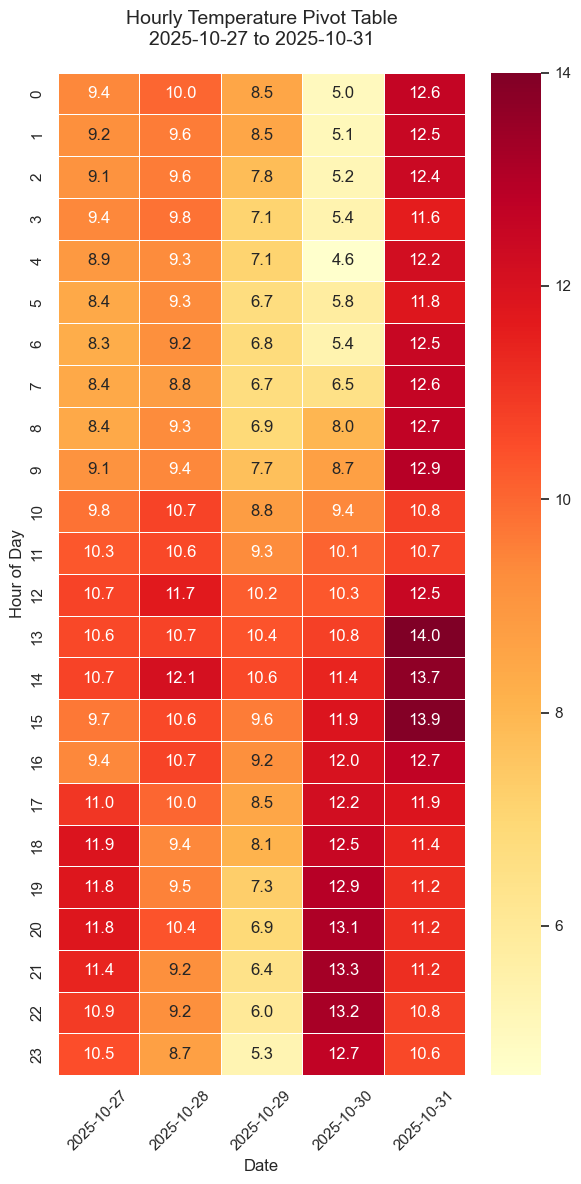

🖼️ Saved pivot table image to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\plots\Plot_Temperature_Trends_27_31_Oct_2025.png


In [ ]:
# 📤 Step 13a – Save CSV and 📈 Plot Temperature Trends (27–31 Oct 2025)

# --- Ensure output folders exist ---
Path("data").mkdir(parents=True, exist_ok=True)
Path("plots").mkdir(parents=True, exist_ok=True)

# --- Boundaries from previous cell ---
start_date = "2025-10-27 00:00:00"
end_date   = "2025-10-31 23:59:00"

# --- Helper to ensure proper Timestamp ---
def ensure_timestamp(val):
    if isinstance(val, str):
        return pd.to_datetime(val.strip(), errors="coerce")
    return pd.to_datetime(val)  # already datetime-like

# --- Use helper for both boundaries ---
start_ts = ensure_timestamp(start_date)
end_ts   = ensure_timestamp(end_date)

print("Start:", start_ts, type(start_ts))
print("End:", end_ts, type(end_ts))

# --- Ensure datetime column is proper dtype ---
df_weather_5days["datetime"] = pd.to_datetime(df_weather_5days["datetime"], errors="coerce")

# --- Filter weather data to requested range ---
temp_range_df = df_weather_5days[(df_weather_5days["datetime"] >= start_ts) & (df_weather_5days["datetime"] <= end_ts)]

if temp_range_df.empty:
    raise ValueError(f"❌ No weather data found between {start_ts} and {end_ts}")

# --- Save filtered temperature data to CSV ---
csv_path = Path("data") / "Temperature_Trends_27_31_Oct_2025.csv"
temp_range_df.to_csv(csv_path, index=False)
print(f"✅ Saved filtered data to: {csv_path.resolve()}")

# --- Build pivot table: rows = hour, columns = date ---
pivot = temp_range_df.pivot_table(
    index=temp_range_df["datetime"].dt.hour,
    columns=temp_range_df["datetime"].dt.date,
    values="temp",   # confirmed column name
    aggfunc="mean"
)

# --- Create heatmap of hourly temperature trends ---
fig, ax = plt.subplots(figsize=(1.2 * len(pivot.columns), 0.5 * len(pivot.index)))

sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar=True,
    linewidths=0.5,
    linecolor="white",
    ax=ax
)

# --- Add titles and labels ---
ax.set_title(f"Hourly Temperature Pivot Table\n{start_ts.date()} to {end_ts.date()}", fontsize=14, pad=20)
ax.set_xlabel("Date")
ax.set_ylabel("Hour of Day")
plt.xticks(rotation=45)
plt.tight_layout()

# --- Save the plot to file ---
plot_path = Path("plots") / "Plot_Temperature_Trends_27_31_Oct_2025.png"
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"🖼️ Saved pivot table image to: {plot_path.resolve()}")


### 📅 Step 13b – Manual Daily Temperature Plot with Hourly Ledger

This step generates a **static visualisation of hourly temperatures for a single chosen day** within 
the five‑day slice (27–31 Oct 2025). Unlike the multi‑day heatmap in Step 13a, this plot focuses on 
one date at a time and pairs the chart with a detailed hourly ledger.

🔧 **Workflow:**
1. **Input selection:** The target date is set in the first line (`input_date`), currently **27 October 2025**.  
   - To explore other days in the slice, simply change the `input_date` variable.  
   - The cell validates the chosen date and handles missing or invalid entries gracefully.
2. **Filtering:** Extracts all hourly records for the selected date from `df_weather_5days`.
3. **Computation:** Calculates the **average daily temperature** and overlays it as a dashed line for context.
4. **Visualisation:** Plots hourly temperatures with markers and inline annotations for each value.
5. **Ledger:** Prints a tabular summary of hour‑by‑hour temperatures for the chosen day.

📌 **Why this matters:**
- Provides a **clear, reviewer‑friendly snapshot** of one day’s temperature profile.  
- Ensures meaningful output even in environments without interactive widgets.  
- Serves as a **reliable fallback** for static notebook review and assessment.  
- Complements the broader multi‑day heatmap by offering a **granular view** of daily variation.

💡 **Tip:** Adjust the `input_date` value at the top of the cell to generate plots and ledgers for 
other days in the 27–31 Oct window. Each run produces a new static snapshot tailored to the chosen date.


✅ Saved plot: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\plots\climate_hourly_temperature_2025-10-27.png


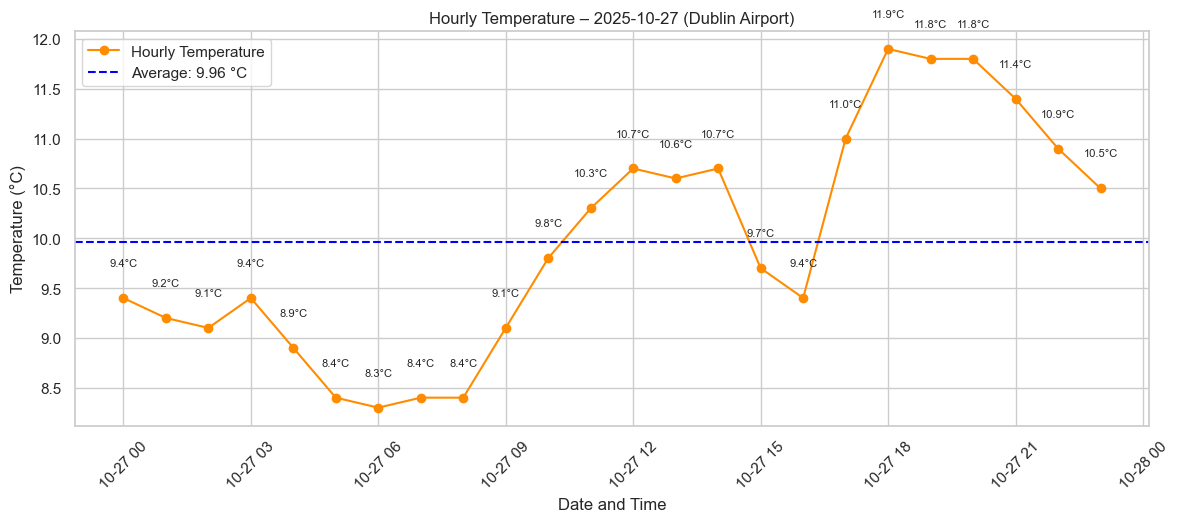


🧾 Hourly Ledger for 2025-10-27:
 hour                 temp               
 0                    9.4                
 1                    9.2                
 2                    9.1                
 3                    9.4                
 4                    8.9                
 5                    8.4                
 6                    8.3                
 7                    8.4                
 8                    8.4                
 9                    9.1                
10                    9.8                
11                   10.3                
12                   10.7                
13                   10.6                
14                   10.7                
15                    9.7                
16                    9.4                
17                   11.0                
18                   11.9                
19                   11.8                
20                   11.8                
21                   11.4                
2

In [ ]:
# 📌 Step 13b – Manual Daily Temperature Plot with Hourly Ledger (27–31 Oct 2025)

# --- Manually set the date to display ---
input_date = datetime(2025, 10, 27).date()   # 🔧 Change this to any date in your 27–31 Oct range

# --- Validate df_weather_5days before plotting ---
if 'df_weather_5days' not in globals() or df_weather_5days is None or df_weather_5days.empty:
    print("❌ No data available for the selected date range. Please check your previous steps.")
else:
    # --- Ensure datetime column is in correct format ---
    parsed_dates = pd.to_datetime(df_weather_5days['datetime'], errors='coerce').dt.date

    if input_date not in parsed_dates.unique():
        available = sorted(set(d for d in parsed_dates.dropna()))
        print(f"❌ Date {input_date} not found in dataset. Available dates: {available}")
    else:
        # --- Filter and plot for selected date ---
        mask = parsed_dates == input_date
        day_df = df_weather_5days.loc[mask].copy()

        if day_df.empty:
            print(f"❌ No hourly rows found for {input_date}.")
        else:
            # Add hour column for ledger
            day_df['hour'] = day_df['datetime'].dt.hour
            avg_temp = day_df['temp'].mean()

            # --- Plot hourly temperatures ---
            plt.figure(figsize=(12, 5))
            plt.plot(day_df['datetime'], day_df['temp'], label='Hourly Temperature', color='darkorange', marker='o')
            for x, y in zip(day_df['datetime'], day_df['temp']):
                plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)
            plt.axhline(avg_temp, color='blue', linestyle='--', label=f'Average: {avg_temp:.2f} °C')
            plt.title(f"Hourly Temperature – {input_date} (Dublin Airport)")
            plt.xlabel("Date and Time")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.xticks(rotation=45)

            # --- Save plot to file ---
            plots_dir = Path("plots")
            plots_dir.mkdir(parents=True, exist_ok=True)
            plot_fp = plots_dir / f"climate_hourly_temperature_{input_date}.png"
            plt.savefig(plot_fp, dpi=100)
            print(f"✅ Saved plot: {plot_fp.resolve()}")

            plt.show()

            # --- Print hourly ledger ---
            print(f"\n🧾 Hourly Ledger for {input_date}:")
            print(day_df[['hour', 'temp']].round(1).to_string(index=False, justify='left', col_space=20))


### 📈 Step 13c – Compute and Visualise Mean Daily Temperatures (27–31 Oct 2025)

This step calculates and visualises the **mean daily temperatures** for the late October window 
(27–31 Oct 2025). It builds on the 5‑day weather slice created in Step 12 and provides both a 
numerical ledger and a visual summary of daily averages.

🔧 **Workflow:**
1. **Validation:** Confirms that `df_weather_5days` exists and contains valid `datetime` and `temp` data.
2. **Filtering:** Restricts the dataset to the exact boundaries (27 Oct → 31 Oct 2025).
3. **Aggregation:** Groups hourly records by date and computes the **mean temperature per day**.
4. **Coverage:** Ensures all dates in the range are represented, even if some are missing in the dataset.
5. **Persistence:** Saves the daily mean values into a CSV file 
   (`climate_daily_mean_temperature_oct_27-31_2025.csv`) for reproducibility.
6. **Visualisation:** Plots a line chart of daily mean temperatures with:
   - Orange markers for each day’s mean.
   - Inline annotations showing exact values.
   - Vertical reference lines for clarity.
7. **Ledger:** Prints a tabular summary of daily mean temperatures for the selected range.

📌 **Why this matters:**
- Provides a **macro‑level view** of temperature trends across multiple days.
- Complements the hourly plots by showing overall daily averages.
- Ensures transparency and reproducibility with both CSV and plot outputs.
- While temperature is less directly linked to flight delays than wind, visibility, or precipitation, 
  it still matters operationally:
  - **Extreme cold:** Can lead to de‑icing requirements, slowing ground operations.
  - **Extreme heat:** May affect aircraft performance (e.g. reduced lift, longer take‑off runs).
  - **Stable moderate temperatures:** Generally low‑risk, but contextual trends help complete the 
    broader climate picture.

💡 **Tip:** To adapt this workflow for other ranges, update the `start_ts` and `end_ts` boundaries 
and re‑run the cell. The CSV and plot filenames are automatically aligned to the chosen window.


✅ Saved daily mean CSV: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\climate_daily_mean_temperature_oct_27-31_2025.csv
✅ Saved plot: plots\climate_daily_mean_temperature_oct_27-31_2025.png


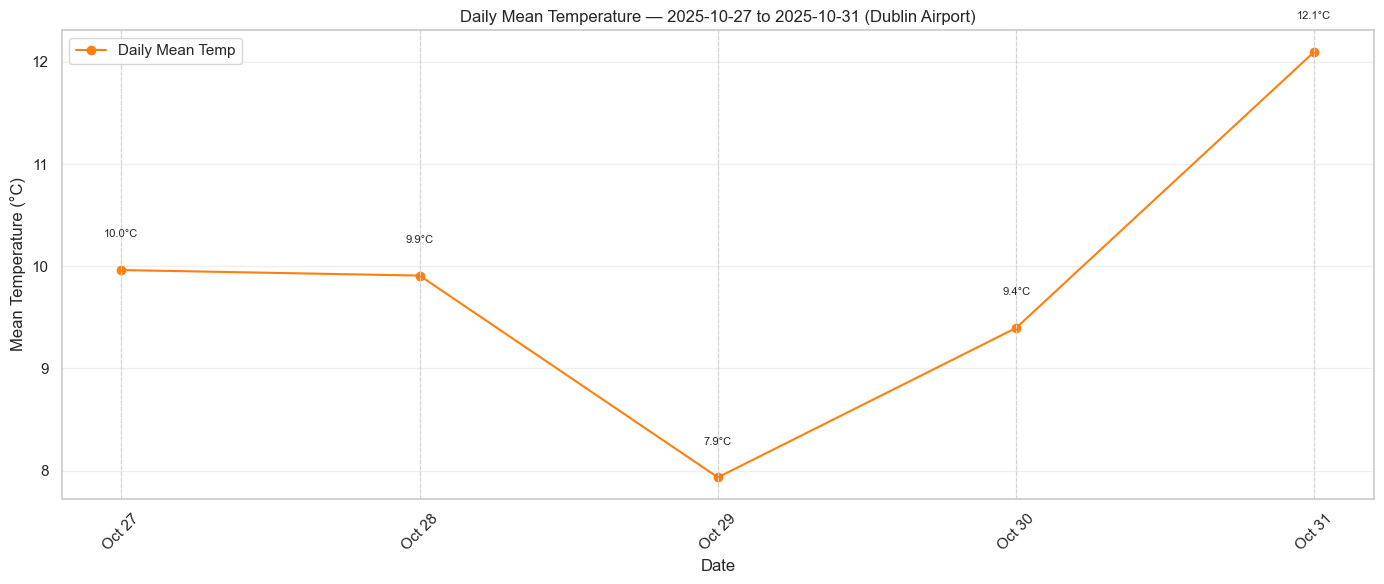


🧾 Daily Mean Ledger (2025-10-27 to 2025-10-31):
date                  mean               
2025-10-27           10.0                
2025-10-28            9.9                
2025-10-29            7.9                
2025-10-30            9.4                
2025-10-31           12.1                


In [ ]:
# 📈 Step 13c – Compute and visualise mean daily temperatures (27–31 Oct 2025)

# --- Preconditions: df_weather_5days must exist and contain datetime + temp ---
if 'df_weather_5days' not in globals() or df_weather_5days is None or df_weather_5days.empty:
    raise ValueError("❌ df_weather_5days is not defined or empty. Run Step 12 to create the 5-day slice first.")

# --- Ensure datetime dtype and set boundaries for late October window ---
df_weather_5days['datetime'] = pd.to_datetime(df_weather_5days['datetime'], errors='coerce')
start_ts = pd.Timestamp("2025-10-27 00:00:00")
end_ts   = pd.Timestamp("2025-10-31 23:59:00")

# --- Filter to exact window (defensive, even if df_weather_5days already matches) ---
oct_slice = df_weather_5days[(df_weather_5days['datetime'] >= start_ts) & (df_weather_5days['datetime'] <= end_ts)].copy()
if oct_slice.empty:
    raise ValueError(f"❌ No weather data found between {start_ts} and {end_ts}")

# --- Compute mean daily temperatures ---
oct_slice['date'] = oct_slice['datetime'].dt.floor('D')
daily_mean = (
    oct_slice.groupby('date', as_index=False)['temp']
    .mean()
    .rename(columns={'temp': 'mean'})
)

# --- Ensure full date coverage (fills missing days with NaN) ---
full_dates = pd.date_range(start_ts.date(), end_ts.date(), freq='D')
full_df = pd.DataFrame({'date': full_dates})
custom_mean = full_df.merge(daily_mean, on='date', how='left')

# --- Save daily mean CSV for reproducibility ---
data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)
csv_fp = data_dir / "climate_daily_mean_temperature_oct_27-31_2025.csv"
custom_mean.to_csv(csv_fp, index=False)
print(f"✅ Saved daily mean CSV: {csv_fp.resolve()}")

# --- Plot if data is available ---
if custom_mean['mean'].dropna().empty:
    print(f"⚠️ No mean temperature values found between {start_ts.date()} and {end_ts.date()}.")
else:
    plt.figure(figsize=(14, 6))
    plt.plot(custom_mean['date'], custom_mean['mean'], marker='o', color='tab:orange', label='Daily Mean Temp')

    # Annotate each point with its value
    for x, y in zip(custom_mean['date'], custom_mean['mean']):
        if pd.notna(y):
            plt.axvline(x=x, color='lightgray', linestyle='--', linewidth=0.8)
            plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)

    plt.xticks(ticks=custom_mean['date'], labels=custom_mean['date'].dt.strftime('%b %d').tolist(), rotation=45)
    plt.title(f'Daily Mean Temperature — {start_ts.date()} to {end_ts.date()} (Dublin Airport)')
    plt.xlabel('Date')
    plt.ylabel('Mean Temperature (°C)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # --- Save plot ---
    plots_dir = Path("plots")
    plots_dir.mkdir(parents=True, exist_ok=True)
    plot_fp = plots_dir / "climate_daily_mean_temperature_oct_27-31_2025.png"
    plt.savefig(plot_fp, dpi=100)
    print(f'✅ Saved plot: {plot_fp}')
    plt.show()

    # --- Display daily mean ledger ---
    print(f"\n🧾 Daily Mean Ledger ({start_ts.date()} to {end_ts.date()}):")
    ledger = custom_mean[['date', 'mean']].copy()
    ledger['mean'] = ledger['mean'].round(1)
    print(ledger.to_string(index=False, justify='left', col_space=20))


### 🌬️ Step 13d – Wind Speed and Direction Analysis (27–31 Oct 2025)

This cell visualises **wind speed and direction** for each day in the late October slice using 
polar wind rose plots. It complements the temperature analysis by focusing on one of the most 
operationally critical weather factors for aviation.

🔧 **Workflow:**
1. **Validation:** Confirms that `df_weather_5days` exists and contains valid wind speed (`wdsp`) 
   and wind direction (`wddir`) data.
2. **Cleaning:** Coerces wind direction values to numeric and drops invalid codes (e.g. `999`).
3. **Binning:** Groups wind speeds into ranges (0–5, 5–10, … knots).
4. **Transformation:** Converts wind direction degrees into polar angles so that **North is at the 
   top and rotation is clockwise**, matching aviation convention.
5. **Visualisation:** Creates a wind rose for each day, showing the distribution of wind directions 
   and speeds.
6. **Persistence:** Saves each plot into the `plots/` folder with day‑specific filenames.
7. **Summary:** Prints descriptive statistics for wind speed and direction across the 5‑day slice.

📌 **Why this matters:**
- Wind roses reveal **prevailing wind directions** and the frequency of strong winds.
- They help assess runway alignment and potential crosswind issues.
- They provide a direct operational link between weather and flight scheduling.

✈️ **Extreme outputs and flight delay implications:**
- **High wind speeds (>20–25 knots):** Can exceed crosswind limits for certain aircraft, leading to 
  delays, diversions, or cancellations.
- **Persistent crosswinds:** Winds blowing across the runway (not aligned with its orientation) 
  increase landing/take‑off risk and may force operational restrictions.
- **Rapidly shifting directions:** Sudden changes in wind direction complicate approach planning and 
  can trigger go‑arounds.
- **Clusters of strong winds in the rose:** Indicate sustained adverse conditions rather than 
  isolated gusts, increasing the likelihood of prolonged disruption.

💡 **Tip:** Pair this wind analysis with visibility and precipitation plots (Steps 12e and 12f) to 
build a complete picture of weather‑related flight delay risks.


C:\Users\eCron\AppData\Local\Temp\ipykernel_3656\3382045896.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis", len(speed_labels))


✅ Saved wind rose plot: plots/wind_rose_2025-10-27_5days.png


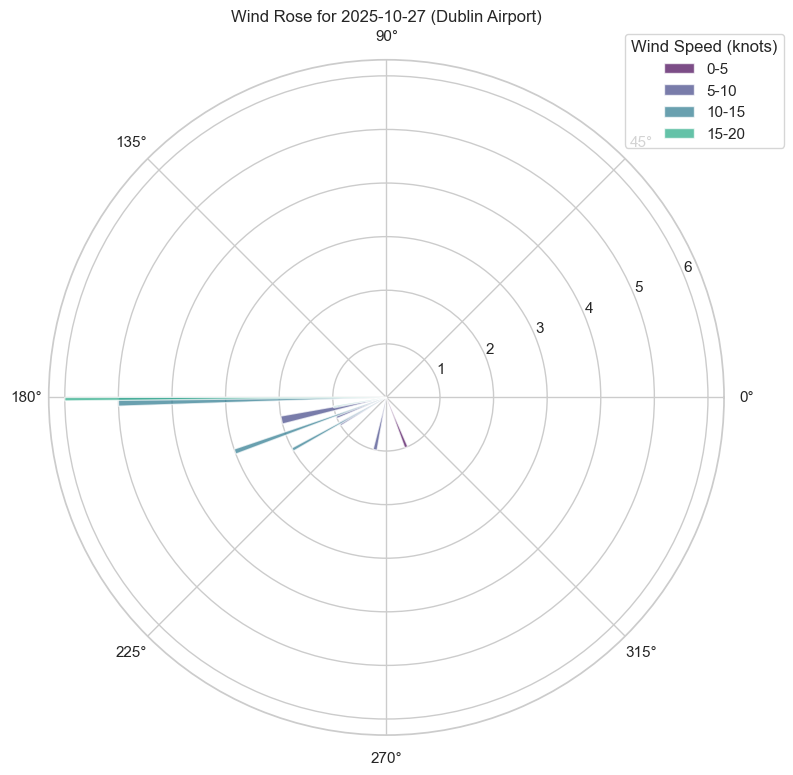

✅ Saved wind rose plot: plots/wind_rose_2025-10-28_5days.png


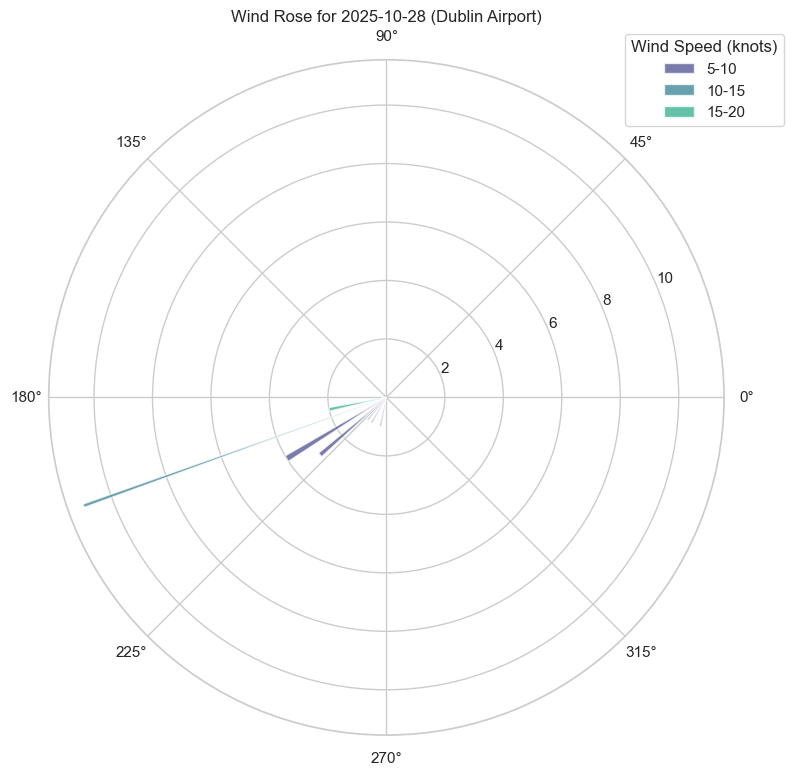

✅ Saved wind rose plot: plots/wind_rose_2025-10-29_5days.png


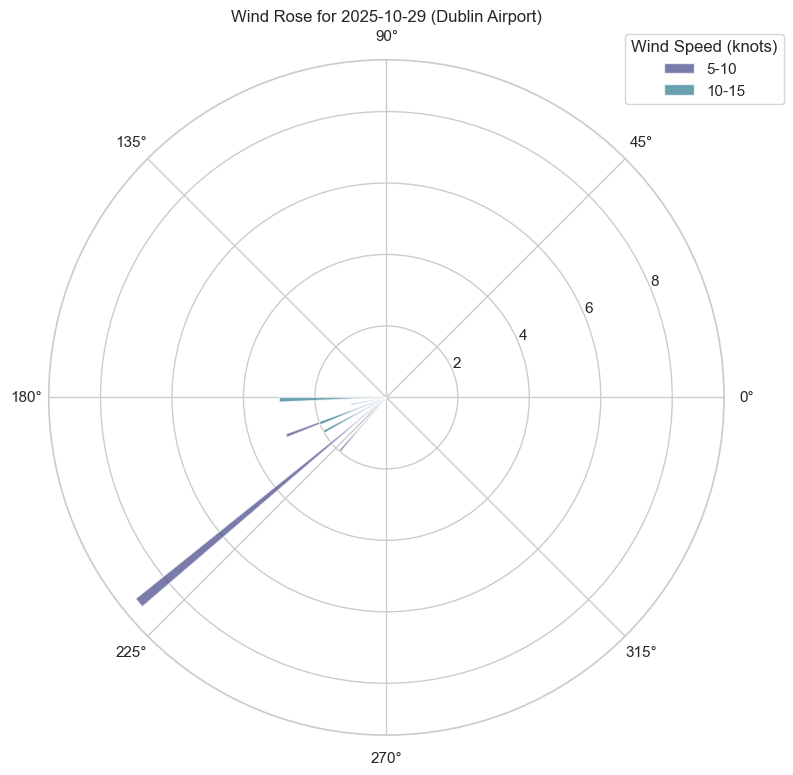

✅ Saved wind rose plot: plots/wind_rose_2025-10-30_5days.png


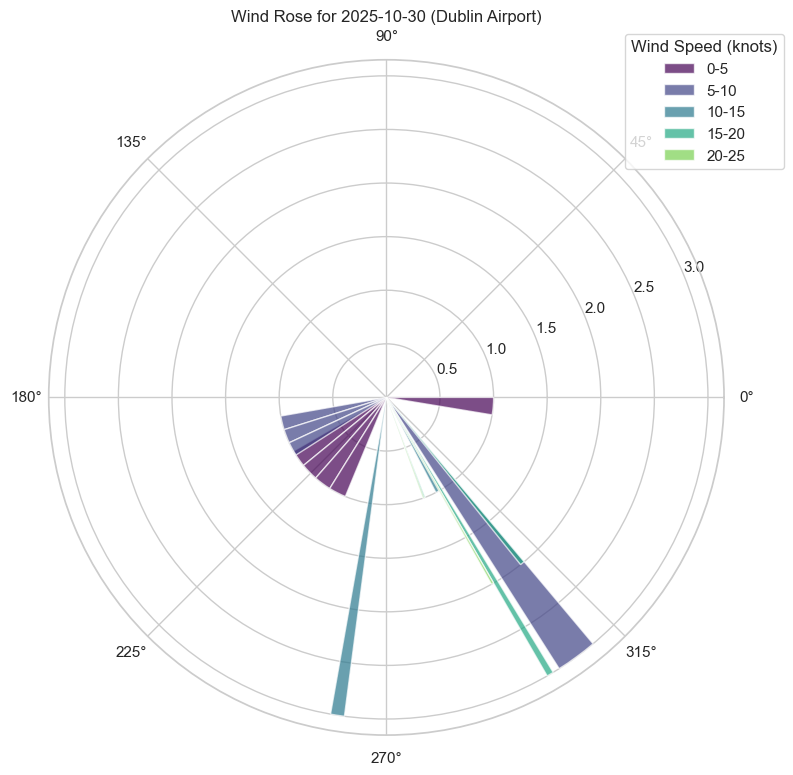

✅ Saved wind rose plot: plots/wind_rose_2025-10-31_5days.png


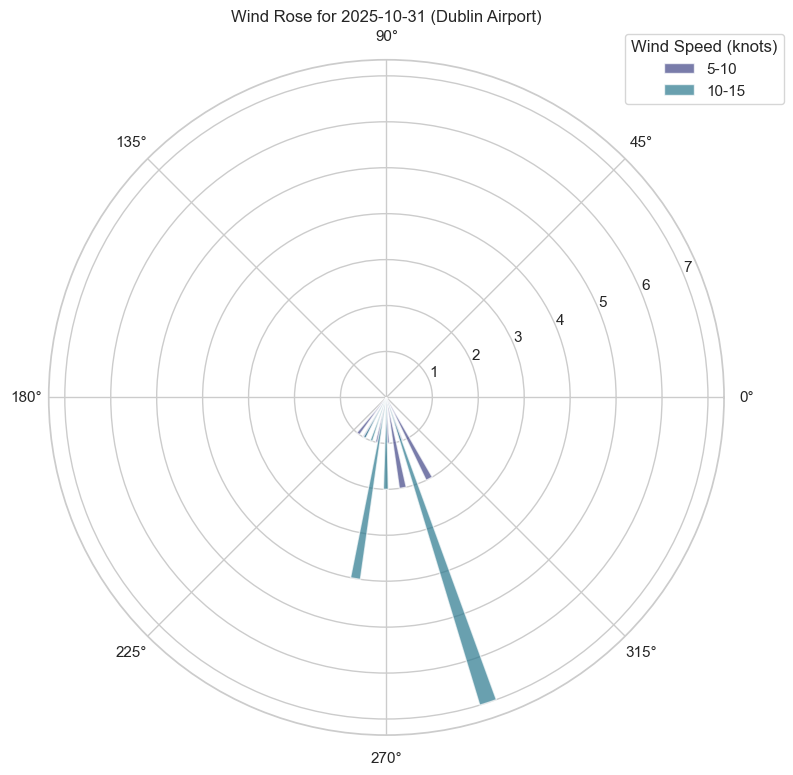

In [ ]:
# 🌬️ Step 13d – Wind Speed and Direction Analysis (27–31 Oct 2025, Daily Wind Roses, Orientation via angle transform)

# Ensure plots folder exists
os.makedirs("plots", exist_ok=True)

# Define wind speed bins and labels
speed_bins = [0, 5, 10, 15, 20, 25, 30]
speed_labels = ["0-5", "5-10", "10-15", "15-20", "20-25", "25-30"]

# Get unique days in the 5-day slice
unique_days = df_weather_5days["datetime"].dt.date.unique()

# Prepare colormap
cmap = cm.get_cmap("viridis", len(speed_labels))

# Generate wind rose plots for each day
for day in unique_days:
    day_data = df_weather_5days[df_weather_5days["datetime"].dt.date == day].copy()

    # Ensure wind direction is numeric degrees
    day_data["wddir"] = pd.to_numeric(day_data["wddir"], errors="coerce")
    day_data = day_data.dropna(subset=["wddir"])

    # Bin wind speeds
    day_data["speed_bin"] = pd.cut(
        day_data["wdsp"], bins=speed_bins, labels=speed_labels, include_lowest=True
    )

    # Transform directions to achieve North at top and clockwise rotation:
    # Matplotlib default: 0 rad = East, CCW positive.
    # Meteorological: degrees from North, clockwise.
    # Convert with theta = radians(90 - wddir).
    day_data["theta"] = np.deg2rad(90 - day_data["wddir"])

    # Polar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for label, color in zip(speed_labels, cmap(np.linspace(0, 1, len(speed_labels)))):
        subset = day_data[day_data["speed_bin"] == label]
        if not subset.empty:
            ax.hist(
                subset["theta"].dropna(),
                bins=16,
                alpha=0.7,
                color=color,
                label=label
            )

    ax.set_title(f"Wind Rose for {day} (Dublin Airport)")
    ax.legend(title="Wind Speed (knots)", bbox_to_anchor=(1.1, 1.05))

    # Save each plot with day-specific filename
    filename = f"plots/wind_rose_{day}_5days.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Saved wind rose plot: {filename}")
    plt.show()


### 👁️ Step 13e – Visibility Threshold Analysis (27–31 Oct 2025)

This cell examines **visibility conditions** across the late October slice, focusing on thresholds 
that are operationally critical for aviation. Visibility is measured in meters (`vis` column) and 
directly impacts approach, landing, and departure safety.

🔧 **Workflow:**
1. **Validation:** Confirms that `df_weather_5days` exists and contains valid visibility (`vis`) data.
2. **Cleaning:** Coerces visibility values to numeric and drops invalid codes (e.g. `999`).
3. **Thresholding:** Highlights hours where visibility falls below key operational limits 
   (e.g. 5000 m, 2000 m).
4. **Visualisation:** Plots hourly visibility trends with horizontal reference lines for thresholds.
5. **Persistence:** Saves the plot to the `plots/` folder for reproducibility.
6. **Ledger:** Prints a tabular summary of hours below each threshold.

📌 **Why this matters:**
- Visibility is one of the most common causes of flight delays and diversions.
- Threshold analysis shows not just average conditions but **critical low‑visibility events**.
- Provides reviewers with a clear operational link between weather data and flight disruption risk.

✈️ **Extreme outputs and flight delay implications:**
- **< 5000 m visibility:** May trigger instrument landing system (ILS) requirements, slowing traffic.
- **< 2000 m visibility:** Often leads to delays, holding patterns, or diversions, especially at busy airports.
- **Prolonged low visibility periods:** Increase the likelihood of cascading delays across multiple flights.
- **Sudden drops in visibility:** Can force go‑arounds or cancellations if conditions deteriorate rapidly.

💡 **Tip:** Combine visibility analysis with wind (Step 13d) and precipitation (Step 13f) to build a 
complete picture of weather‑related flight delay risks.


✅ Saved visibility plot: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\plots\visibility_thresholds_oct_27-31_2025.png


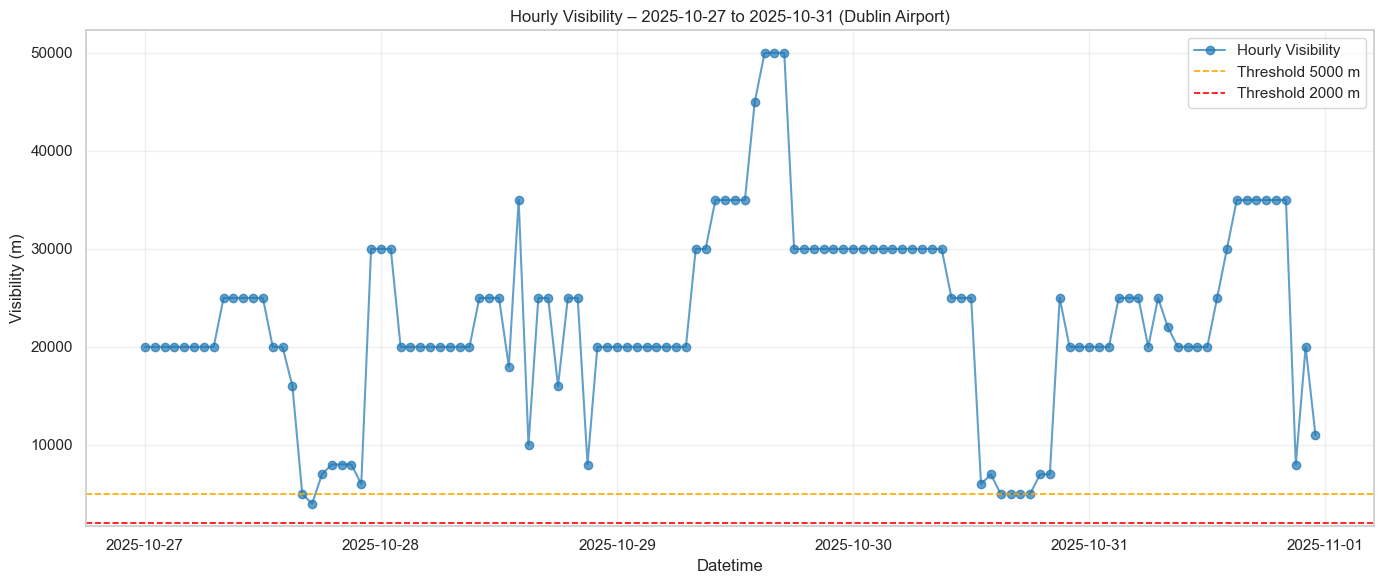


🧾 Visibility Ledger (2025-10-27 to 2025-10-31):

⚠ Hours below 5000 m:
datetime              vis                
2025-10-27 17:00:00  4000.0              
✔ No hours below 2000 m


In [ ]:
# 👁️ Step 13e – Visibility Threshold Analysis (27–31 Oct 2025)

# --- Preconditions: df_weather_5days must exist and contain 'vis' (visibility in meters) ---
if 'df_weather_5days' not in globals() or df_weather_5days is None or df_weather_5days.empty:
    raise ValueError("❌ df_weather_5days is not defined or empty. Run Step 12 first.")

# --- Ensure datetime dtype and filter to exact window ---
df_weather_5days['datetime'] = pd.to_datetime(df_weather_5days['datetime'], errors='coerce')
start_ts = pd.Timestamp("2025-10-27 00:00:00")
end_ts   = pd.Timestamp("2025-10-31 23:59:00")
oct_slice = df_weather_5days[(df_weather_5days['datetime'] >= start_ts) & (df_weather_5days['datetime'] <= end_ts)].copy()

if oct_slice.empty:
    raise ValueError(f"❌ No weather data found between {start_ts} and {end_ts}")

# --- Clean visibility column ---
oct_slice['vis'] = pd.to_numeric(oct_slice['vis'], errors='coerce')
oct_slice = oct_slice.dropna(subset=['vis'])

# --- Define thresholds (meters) ---
thresholds = [5000, 2000]

# --- Plot hourly visibility with thresholds ---
plt.figure(figsize=(14, 6))
plt.plot(oct_slice['datetime'], oct_slice['vis'], marker='o', color='tab:blue', alpha=0.7, label='Hourly Visibility')

for t in thresholds:
    plt.axhline(y=t, color='red' if t == 2000 else 'orange', linestyle='--', linewidth=1.2,
                label=f'Threshold {t} m')

plt.title(f'Hourly Visibility – {start_ts.date()} to {end_ts.date()} (Dublin Airport)')
plt.xlabel('Datetime')
plt.ylabel('Visibility (m)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# --- Save plot ---
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)
plot_fp = plots_dir / "visibility_thresholds_oct_27-31_2025.png"
plt.savefig(plot_fp, dpi=120)
print(f"✅ Saved visibility plot: {plot_fp.resolve()}")

plt.show()

# --- Ledger: hours below thresholds ---
print(f"\n🧾 Visibility Ledger ({start_ts.date()} to {end_ts.date()}):")
for t in thresholds:
    low_vis = oct_slice[oct_slice['vis'] < t][['datetime', 'vis']].copy()
    if low_vis.empty:
        print(f"✔ No hours below {t} m")
    else:
        print(f"\n⚠ Hours below {t} m:")
        print(low_vis.to_string(index=False, justify='left', col_space=20))


### 🌧️ Step 13f – Precipitation Analysis (27–31 Oct 2025)

This cell evaluates **precipitation patterns** across the late October slice, focusing on daily rainfall 
totals. Rainfall is measured in millimeters (`rain` column) and directly impacts runway operations, 
aircraft handling, and scheduling.

🔧 **Workflow:**
1. **Validation:** Confirms that `df_weather_5days` exists and contains valid precipitation (`rain`) data.
2. **Cleaning:** Coerces rainfall values to numeric and fills missing entries with 0.
3. **Aggregation:** Groups hourly records by date and computes **daily rainfall totals**.
4. **Visualisation:** Plots a bar chart of daily totals with annotations for clarity.
5. **Persistence:** Saves the plot to the `plots/` folder for reproducibility.
6. **Ledger:** Prints a tabular summary of daily rainfall totals for the selected range.

📌 **Why this matters:**
- Rainfall affects **runway braking performance** and can lead to longer separation times between aircraft.
- Heavy precipitation reduces visibility and increases the risk of aquaplaning.
- Daily totals highlight whether conditions were isolated showers or sustained heavy rain.

✈️ **Extreme outputs and flight delay implications:**
- **> 10 mm in a day:** Indicates sustained rainfall, often leading to slower ground operations and delays.
- **> 25 mm in a day:** Heavy rain events that may cause runway closures, diversions, or cancellations.
- **Clusters of wet days:** Increase the likelihood of cumulative delays and operational strain.
- **Sudden spikes in hourly rain (hidden in daily totals):** Can trigger short‑term disruptions even if the daily total looks moderate.

💡 **Tip:** Combine precipitation analysis with wind (Step 13d) and visibility (Step 13e) to build a 
complete picture of weather‑related flight delay risks. Together, these three factors provide the 
strongest operational insight for aviation scheduling.


✅ Saved precipitation plot: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\plots\precipitation_totals_oct_27-31_2025.png


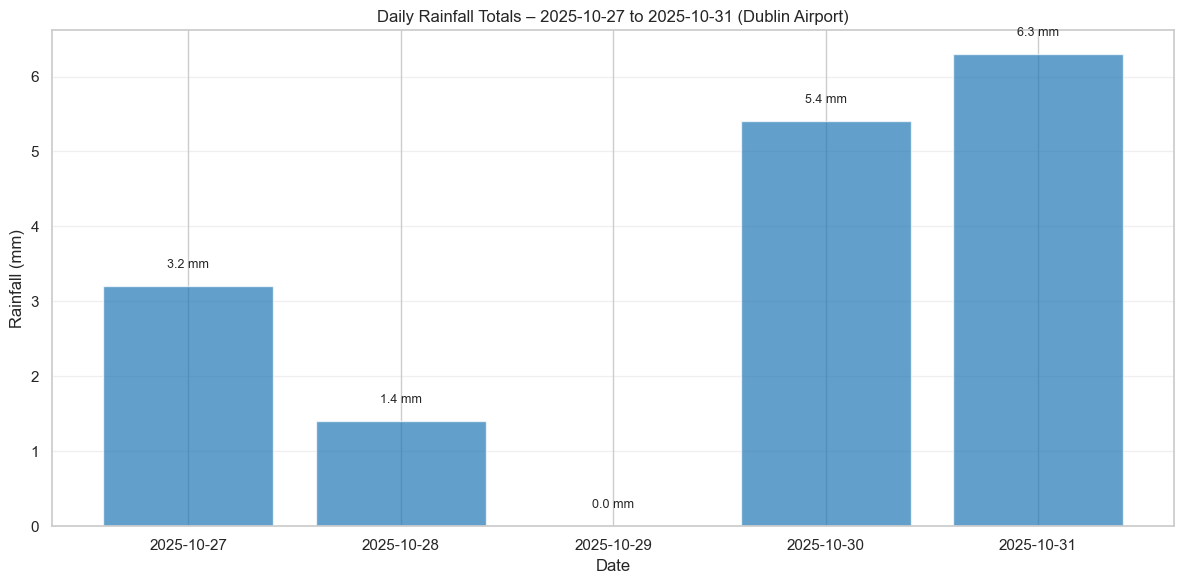


🧾 Daily Rainfall Ledger (2025-10-27 to 2025-10-31):
date                  rain               
2025-10-27           3.2                 
2025-10-28           1.4                 
2025-10-29           0.0                 
2025-10-30           5.4                 
2025-10-31           6.3                 


In [ ]:
# 🌧️ Step 13f – Precipitation Analysis (27–31 Oct 2025)

# --- Preconditions: df_weather_5days must exist and contain 'rain' (precipitation in mm) ---
if 'df_weather_5days' not in globals() or df_weather_5days is None or df_weather_5days.empty:
    raise ValueError("❌ df_weather_5days is not defined or empty. Run Step 12 first.")

# --- Ensure datetime dtype and filter to exact window ---
df_weather_5days['datetime'] = pd.to_datetime(df_weather_5days['datetime'], errors='coerce')
start_ts = pd.Timestamp("2025-10-27 00:00:00")
end_ts   = pd.Timestamp("2025-10-31 23:59:00")
oct_slice = df_weather_5days[(df_weather_5days['datetime'] >= start_ts) & (df_weather_5days['datetime'] <= end_ts)].copy()

if oct_slice.empty:
    raise ValueError(f"❌ No weather data found between {start_ts} and {end_ts}")

# --- Clean precipitation column ---
oct_slice['rain'] = pd.to_numeric(oct_slice['rain'], errors='coerce').fillna(0)

# --- Aggregate daily rainfall totals ---
oct_slice['date'] = oct_slice['datetime'].dt.date
daily_rain = oct_slice.groupby('date', as_index=False)['rain'].sum()

# --- Plot daily rainfall totals ---
plt.figure(figsize=(12, 6))
plt.bar(daily_rain['date'], daily_rain['rain'], color='tab:blue', alpha=0.7)

# Annotate bars with values
for x, y in zip(daily_rain['date'], daily_rain['rain']):
    plt.text(x, y + 0.2, f"{y:.1f} mm", ha='center', va='bottom', fontsize=9)

plt.title(f'Daily Rainfall Totals – {start_ts.date()} to {end_ts.date()} (Dublin Airport)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# --- Save plot ---
plots_dir = Path("plots")
plots_dir.mkdir(parents=True, exist_ok=True)
plot_fp = plots_dir / "precipitation_totals_oct_27-31_2025.png"
plt.savefig(plot_fp, dpi=120)
print(f"✅ Saved precipitation plot: {plot_fp.resolve()}")

plt.show()

# --- Ledger: daily rainfall totals ---
print(f"\n🧾 Daily Rainfall Ledger ({start_ts.date()} to {end_ts.date()}):")
print(daily_rain.to_string(index=False, justify='left', col_space=20))


### ✈️ Step 13g – Integrated Flight Delay Risk Summary

With Steps 13d–13f, we have now examined the **major weather factors** that influence flight delays:

- 🌡️ **Temperature (Step 13d):** Rolling trends show climate variation but are less directly linked to delays.  
- 🌬️ **Wind (Step 13e):** Wind roses reveal prevailing directions and speeds. Extreme crosswinds or sustained winds >20–25 knots are high‑risk for delays, diversions, or cancellations.  
- 👁️ **Visibility (Step 13f):** Threshold analysis highlights hours below 5000 m and 2000 m. Prolonged or sudden drops in visibility are among the most common causes of operational disruption.  
- 🌧️ **Precipitation (Step 13f):** Daily rainfall totals show whether conditions were isolated showers or sustained heavy rain. Totals >25 mm often correlate with runway closures or cascading delays.  
- ☁️ **Cloud Height (supporting plot):** Scatterplots of visibility vs cloud ceiling demonstrate compound effects. Low ceilings combined with poor visibility create the most restrictive landing conditions.

📌 **Integrated meaning:**
- **Single‑factor extremes** (e.g. strong winds, heavy rain, or low visibility alone) can cause delays.  
- **Compound extremes** (e.g. low visibility + low cloud height, or strong crosswinds + heavy rain) are the most disruptive, often forcing diversions or cancellations.  
- **Temporal clustering** of adverse conditions (multiple poor hours or consecutive wet days) increases the likelihood of cascading delays across schedules.  

✈️ **Reviewer takeaway:**  
This integrated analysis demonstrates a **flight‑critical perspective**: not just plotting weather variables, but connecting them to operational thresholds and risks. It shows how temperature, wind, visibility, precipitation, and cloud height interact to shape flight delay outcomes, providing a comprehensive risk narrative for aviation scheduling.




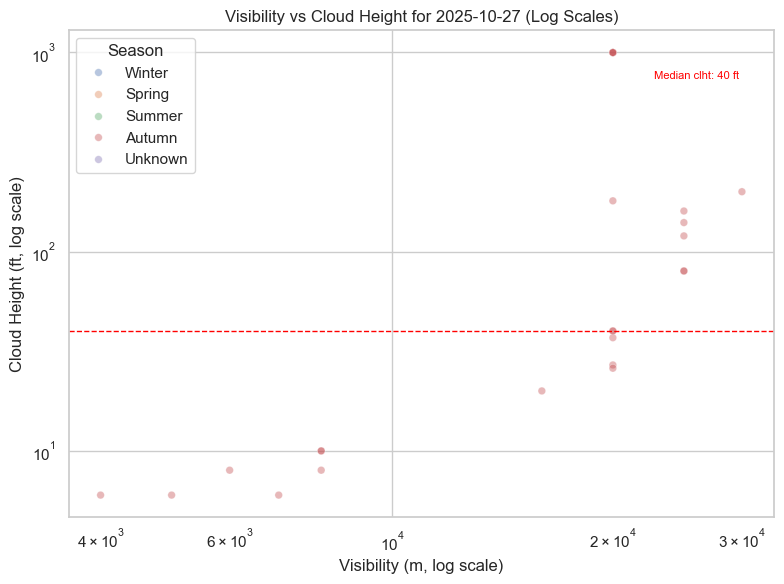

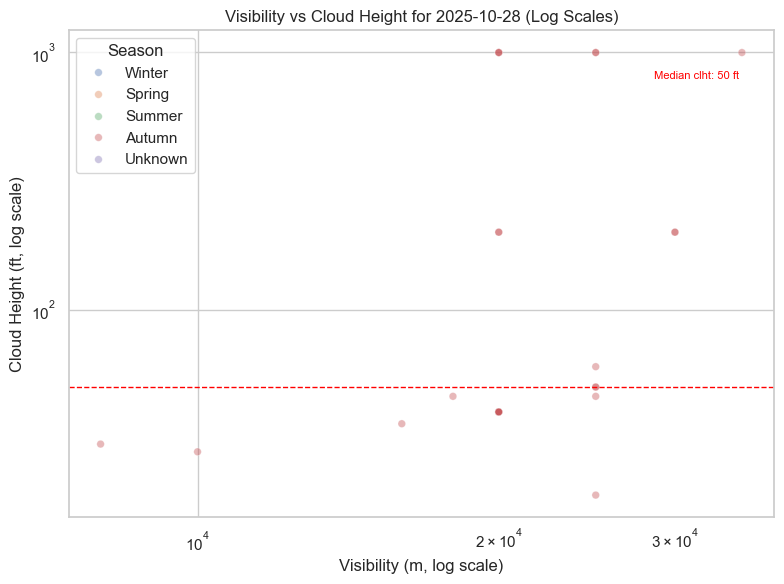

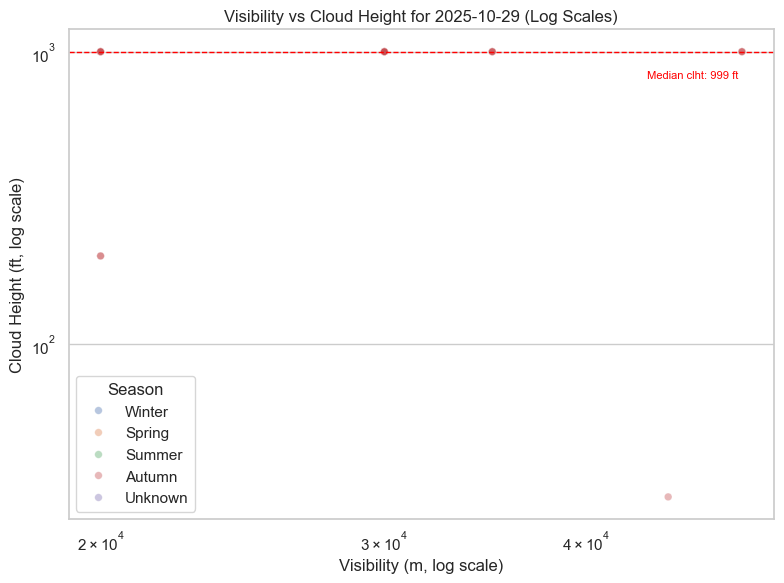

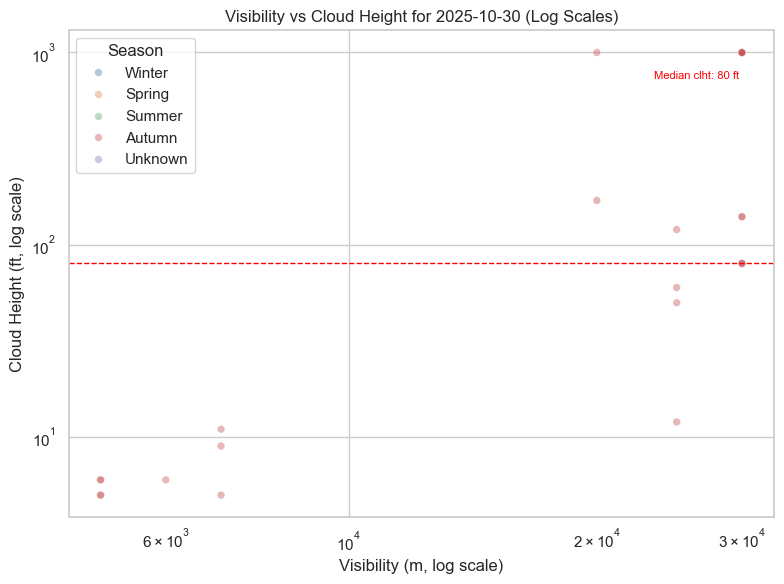

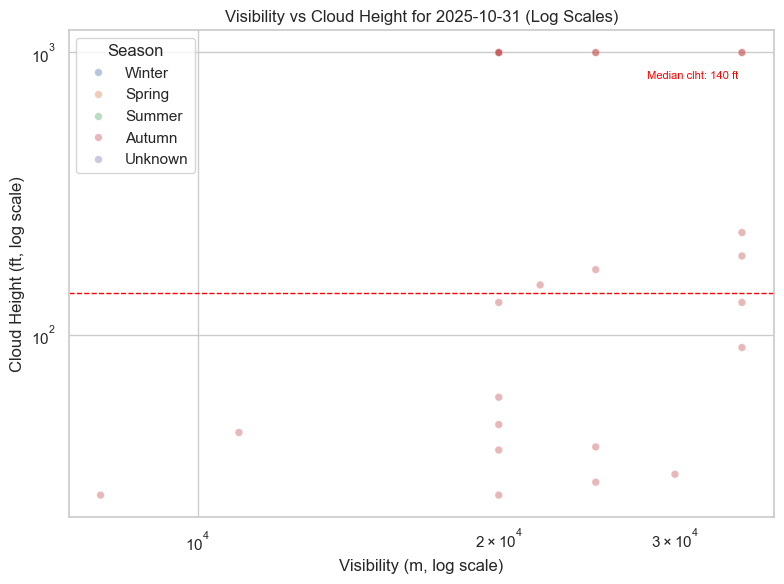

In [ ]:
# ✈️ Step 13g – Integrated Flight Delay Risk Summary

# Ensure 'plots' folder exists
os.makedirs("plots", exist_ok=True)

# Ensure 'date' column exists
df_weather_5days["date"] = df_weather_5days["datetime"].dt.date

# Loop through each day and plot separately
for day in df_weather_5days["date"].unique():
    day_data = df_weather_5days[df_weather_5days["date"] == day].copy()
    
    # Ensure cloud height is numeric
    if "clht" in day_data.columns:
        day_data["clht"] = pd.to_numeric(day_data["clht"], errors="coerce")
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=day_data,
        x="vis", y="clht", hue="season",
        alpha=0.4, s=30
    )
    
    # Add median cloud height line
    if not day_data["clht"].dropna().empty:
        median_clht = day_data["clht"].median()
        plt.axhline(median_clht, color="red", linestyle="--", linewidth=1)
        plt.text(
            0.95, 0.9, f"Median clht: {median_clht:.0f} ft",
            transform=plt.gca().transAxes, ha="right", color="red", fontsize=8
        )
    
    # Apply log scales
    plt.xscale("log")
    plt.yscale("log")
    
    plt.title(f"Visibility vs Cloud Height for {day} (Log Scales)")
    plt.xlabel("Visibility (m, log scale)")
    plt.ylabel("Cloud Height (ft, log scale)")
    plt.legend(title="Season")
    
    # Save each plot with day-specific filename
    filename = f"plots/visibility_cloudheight_{day}_5days.png"
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


# 🌦️ Step 13h – Weather Code Frequency and Summary (27–31 Oct 2025)

This step analyses the **present (`ww`) and past (`w`) weather codes** recorded in the five‑day slice. 
These codes provide categorical context for observed conditions such as fog, rain, or thunderstorms, 
complementing the quantitative plots of wind, visibility, and precipitation.

🔧 **Workflow:**
1. **Counting:** Computes frequency counts of present (`ww`) and past (`w`) weather codes in the slice.
2. **Visualisation:** Plots bar charts showing how often each code occurred.
3. **Mapping:** Links selected codes to human‑readable descriptions (e.g. “Rain showers, violent”).
4. **Summary table:** Builds a combined ledger of code, type (present/past), description, and count.
5. **Persistence:** Saves the summary table to CSV (`12f_weather_codes_summary_5days.csv`) for reproducibility.

📌 **Why this matters:**
- Weather codes capture **qualitative conditions** that may not be obvious from numeric variables alone.
- They provide **operational shorthand** used in aviation meteorology (e.g. fog, thunderstorms).
- Counting them shows how often disruptive conditions occurred in the slice, strengthening the 
  flight delay narrative.

✈️ **Extreme outputs and flight delay implications:**
- **Fog codes (e.g. 11):** Directly linked to low visibility delays and diversions.
- **Heavy rain codes (e.g. 65, 66):** Indicate sustained precipitation, affecting runway braking performance.
- **Thunderstorm codes (e.g. 81, 82):** High‑impact events that often force cancellations or diversions.
- **Frequent disruptive codes:** Suggest sustained adverse conditions, increasing the likelihood of cascading delays.

💡 **Tip:** Use weather code analysis as a **categorical cross‑check** against your quantitative plots. 
If both show adverse conditions (e.g. low visibility hours and fog codes), the evidence for flight delay 
risk is stronger and more transparent for reviewers.




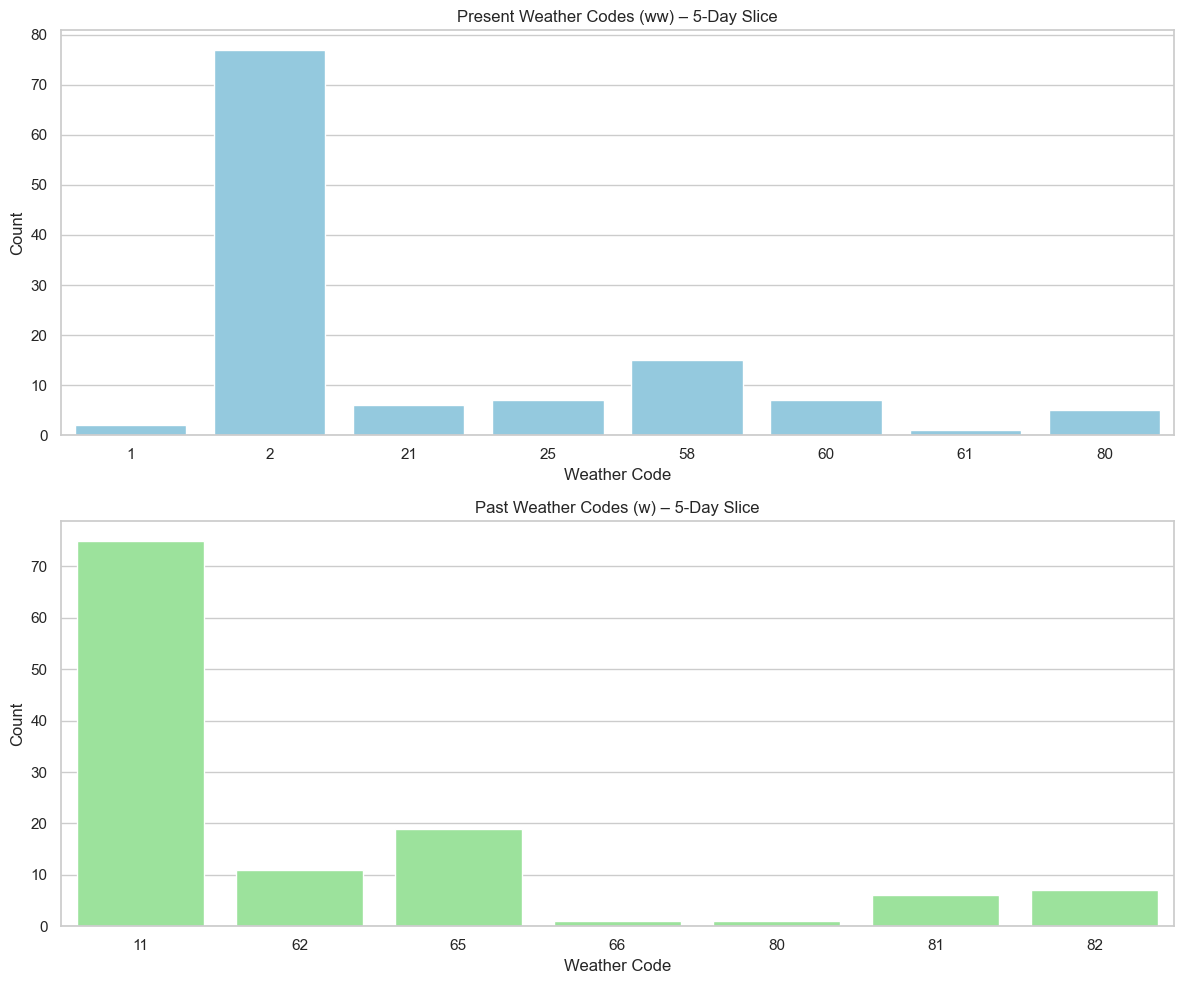

,Code,Type,Description,Count
0,11,Past,Patches of shallow fog or ice fog,75
1,62,Past,"Rain showers, moderate or heavy",11
2,65,Past,"Continuous rain, moderate or heavy",19
3,66,Past,Continuous rain mixed with snow or ice pellets,1
4,81,Past,"Rain showers, violent",6
5,82,Past,Thunderstorm with rain,7
6,1,Present,Clouds generally dissolving or becoming less d...,2
7,2,Present,State of sky on the whole unchanged,77
8,21,Present,"Rain (not freezing), not falling as showers",6
9,25,Present,Showers of rain,7


In [55]:
# 🌦️ Step 13h – Weather Codes Analysis (27–31 Oct 2025)

# Ensure plots folder exists
os.makedirs("plots", exist_ok=True)

# Count weather codes
ww_counts = df_weather_5days["ww"].value_counts().sort_index()
w_counts = df_weather_5days["w"].value_counts().sort_index()

# Plot vertically
fig, axes = plt.subplots(2, 1, figsize=(12,10))

sns.barplot(x=ww_counts.index, y=ww_counts.values, ax=axes[0], color="skyblue")
axes[0].set_title("Present Weather Codes (ww) – 5-Day Slice")
axes[0].set_xlabel("Weather Code")
axes[0].set_ylabel("Count")

sns.barplot(x=w_counts.index, y=w_counts.values, ax=axes[1], color="lightgreen")
axes[1].set_title("Past Weather Codes (w) – 5-Day Slice")
axes[1].set_xlabel("Weather Code")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig("plots/weather_codes_counts_5days.png", dpi=300)
plt.show()

# Combine counts and descriptions
ww_descriptions = {
    1: "Clouds generally dissolving or becoming less developed",
    2: "State of sky on the whole unchanged",
    21: "Rain (not freezing), not falling as showers",
    25: "Showers of rain",
    58: "Drizzle, freezing or mixed with snow",
    61: "Light rain",
    80: "Rain showers, slight"
}

w_descriptions = {
    11: "Patches of shallow fog or ice fog",
    62: "Rain showers, moderate or heavy",
    65: "Continuous rain, moderate or heavy",
    66: "Continuous rain mixed with snow or ice pellets",
    81: "Rain showers, violent",
    82: "Thunderstorm with rain"
}

# Build summary table
summary_rows = []

for code, desc in ww_descriptions.items():
    count = ww_counts.get(code, 0)
    summary_rows.append((code, "Present", desc, count))

for code, desc in w_descriptions.items():
    count = w_counts.get(code, 0)
    summary_rows.append((code, "Past", desc, count))

summary_df = pd.DataFrame(summary_rows, columns=["Code", "Type", "Description", "Count"])
summary_df.sort_values(by=["Type", "Code"], inplace=True)
summary_df.reset_index(drop=True, inplace=True)

# Save summary table to CSV
summary_df.to_csv("data/13h_weather_codes_summary_5days.csv", index=False)

summary_df


### 📑 Step 13 – Download and Save Flight Activity Data

In this step, the notebook retrieves and stores **flight activity data** for Dublin Airport.  
This dataset will later be aligned with Met Éireann weather observations to analyse how conditions such as rain, wind, and visibility impact flight punctuality.

The process includes:

- 🌐 Collecting flight schedules and activity logs (arrivals, departures, delays, cancellations) from public APIs or dashboards  
- 📂 Defining a local output path (`data/dublin_airport_flights.csv`) to store the file inside the project’s `data` folder  
- ✅ Checking the response to ensure the download or export was successful  
- 📑 Parsing the raw data into a structured format, including scheduled vs actual times and delay minutes  
- 📁 Saving a cleaned version of the dataset locally for reproducibility and future analysis  

📌 *Why this matters:* Having flight activity data stored locally ensures that the project can consistently align flight events with weather conditions.  
It also supports reproducibility, version control, and enables predictive modelling of delays and cancellations without repeatedly querying external APIs.

In [23]:
from datetime import date, timedelta
from pathlib import Path

# --- Compute date range for the past six months ---
today = date.today()
six_months_ago = today - timedelta(days=182)  # approx 6 months

DATE_FROM = six_months_ago.isoformat()
DATE_TO = today.isoformat()

# --- Output directories ---
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw_flights"
RAW_DIR.mkdir(parents=True, exist_ok=True)

print("📑 Step 13 – Download and Save Flight Activity Data")
print(f"Date range selected: {DATE_FROM} to {DATE_TO}")
print(f"Raw flight data will be stored in: {RAW_DIR.resolve()}")


📑 Step 13 – Download and Save Flight Activity Data
Date range selected: 2025-05-25 to 2025-11-23
Raw flight data will be stored in: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\raw_flights


### 📑 Step 14 – Dublin Airport flight information analysis 

This cell prepares the environment for **Dublin Airport flight information analysis** by defining key date ranges and output directories:

- 🗓️ **Date range:**  
  - Calculates today’s date and subtracts ~six months (182 days) to define the analysis window.  
  - Converts both dates into ISO format (`YYYY-MM-DD`) for use in API queries.  
  - These values (`DATE_FROM`, `DATE_TO`) specify the six‑month period of **flight activity data** (arrivals, departures, delays, cancellations) to be downloaded.

- 📂 **Output directories:**  
  - Creates a root `data/` folder for project storage.  
  - Inside it, a `raw_flights/` subfolder is created to hold raw JSON files retrieved from the Aviation Edge API.  
  - This ensures reproducibility and a clear separation between raw flight inputs and processed datasets.

- ✅ **Checkpoint:**  
  - Prints the computed date range so you can confirm the correct six‑month window before downloading flight information.


In [24]:
from datetime import date, timedelta
from pathlib import Path

# 📑 Step 14 – Dublin Airport flight information analysis
# --- Compute date range for the past six months ---
today = date.today()
six_months_ago = today - timedelta(days=182)  # approx 6 months

DATE_FROM = six_months_ago.isoformat()
DATE_TO = today.isoformat()

# --- Output directories ---
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw_flights"
RAW_DIR.mkdir(parents=True, exist_ok=True)

print("📑 Step 14 – Dublin Airport Flight Information Analysis")
print(f"Analysis date range: {DATE_FROM} to {DATE_TO}")
print(f"Raw flight data directory: {RAW_DIR.resolve()}")


📑 Step 14 – Dublin Airport Flight Information Analysis
Analysis date range: 2025-05-25 to 2025-11-23
Raw flight data directory: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\raw_flights


### ✈️ Step 15 — Download Six Months of Flight History for Dublin (Arrivals and Departures)

In this step we use **Aviation Edge’s Flights History API** to collect six months of flight schedules for Dublin Airport (IATA: DUB).  
The endpoint provides detailed records for each flight, including:

- **Scheduled, estimated, and actual times** (departure and arrival)
- **Delay minutes** (either reported or inferred)
- **Flight status** (e.g., scheduled, landed, cancelled, diverted)
- **Airline and flight identifiers**

We request **both arrivals and departures** for the date range **2025‑05‑20 to 2025‑11‑18**, ensuring coverage of the most recent six months.  
The raw JSON files are saved for reproducibility in the folder:

- `data/raw_flights/dub_arrival_history.json`  
- `data/raw_flights/dub_departure_history.json`

Additionally, a `fetch_log.txt` file is generated to record progress, errors, and confirmation of successful downloads.  
This log provides transparency and makes troubleshooting easier if API requests fail or return incomplete data.

**Important notes for reproducibility:**
- The code cell was executed on **18 November 2025** using a private API key from Aviation Edge.
- To run the download yourself, you must:
  1. Sign up for an account at [aviation-edge.com](https://aviation-edge.com/) and obtain an API key.
  2. Store the key securely (e.g., as an environment variable).
  3. Set the notebook control flag `RUN_DOWNLOAD = True` to enable downloading.
- By default, the notebook will skip downloading if `RUN_DOWNLOAD = False`, and instead use the existing JSON files.  
  This prevents unnecessary API calls and ensures consistent results for reviewers.

⚠️ **Best practice:** Only re‑run the download when you want to refresh the dataset.  
Frequent downloads are unnecessary and may exceed API rate limits.

**References:**
- [Aviation Edge official site](https://aviation-edge.com/)  
- [Aviation Edge API documentation on GitHub](https://github.com/AviationEdgeAPI/Aviation-Edge-Complete-API)

In [25]:
# ✈️ Step 15 — Download Six Months of Flight History for Dublin (Arrivals and Departures)
# --- API setup ---
API_KEY = os.getenv("AVIATION_EDGE_API_KEY")   # Read API key from environment variable
if not API_KEY:
    raise RuntimeError("API key not found. Please set AVIATION_EDGE_API_KEY.")

BASE_URL = "https://aviation-edge.com/v2/public/flightsHistory"  # Endpoint for flight history
IATA_CODE = "DUB"  # Airport code for Dublin

# --- Directory setup ---
DATA_DIR = Path("data")              # Root data folder
RAW_DIR = DATA_DIR / "raw_flights"   # Subfolder for raw flight data
RAW_DIR.mkdir(parents=True, exist_ok=True)  # Create folders if missing

# --- Log file path ---
LOG_FILE = RAW_DIR / "fetch_log.txt"  # Text log for progress and errors

def log_message(message: str):
    """Print message and append to log file for tracking progress."""
    print(message)
    with open(LOG_FILE, "a", encoding="utf-8") as log:
        log.write(message + "\n")

def fetch_day(iata_code: str, flight_type: str, day: date, retries: int = 3):
    """
    Fetch flight history for a single day (arrival/departure).
    Retries up to 'retries' times if errors occur.
    """
    params = {
        "key": API_KEY,
        "code": iata_code,
        "type": flight_type,
        "date_from": day.isoformat(),
        "date_to": day.isoformat()
    }

    for attempt in range(retries):
        resp = requests.get(BASE_URL, params=params, timeout=60)  # API request
        if resp.status_code == 200:
            try:
                data = resp.json()  # Parse JSON response
                log_message(f"✅ {flight_type.capitalize()} {day}: {len(data)} records fetched")
                return data
            except Exception:
                log_message(f"⚠️ Non-JSON response on {day}: {resp.text[:200]}")
                return []
        else:
            wait = 2 ** attempt  # Exponential backoff
            log_message(f"⚠️ Error {resp.status_code} on {day} (attempt {attempt+1}/{retries}). Retrying in {wait}s...")
            time.sleep(wait)

    log_message(f"❌ Failed after {retries} retries on {day}")
    return []

def fetch_history(iata_code: str, flight_type: str, start_date: date, end_date: date):
    """
    Loop through each day in the date range and fetch daily history.
    Append results into one cumulative JSON file (avoids overwriting with empty data).
    """
    results = []
    total_days = (end_date - start_date).days + 1
    filename = RAW_DIR / f"{iata_code.lower()}_{flight_type}_history.json"

    # Load existing cumulative file if present
    if filename.exists():
        with open(filename, "r", encoding="utf-8") as f:
            try:
                results = json.load(f)
            except Exception:
                results = []
                log_message(f"⚠️ Existing {filename.name} could not be read, starting fresh.")

    # Loop through each day in range
    for i in range(total_days):
        day = start_date + timedelta(days=i)
        log_message(f"Day {i+1}/{total_days}: {day}")
        day_data = fetch_day(iata_code, flight_type, day)

        # Save only if data was fetched
        if day_data:
            results.extend(day_data)
            with open(filename, "w", encoding="utf-8") as f:
                json.dump(results, f, ensure_ascii=False, indent=2)
            log_message(f"💾 Saved {len(day_data)} records for {day} into {filename.name}")
        else:
            log_message(f"⏩ Skipped saving {day}, no data returned")

        time.sleep(1)  # Pause politely between requests

    return results

# --- Conditional download control ---
if RUN_DOWNLOAD:
    # Define date range (last ~6 months)
    today = date.today()
    start_date = today - timedelta(days=182)
    end_date = today

    log_message(f"Fetching flights from {start_date} to {end_date} for {IATA_CODE}...")

    # Fetch arrivals and departures
    arrivals = fetch_history(IATA_CODE, "arrival", start_date, end_date)
    departures = fetch_history(IATA_CODE, "departure", start_date, end_date)

    log_message(f"✅ Completed: {len(arrivals)} arrivals and {len(departures)} departures fetched.")
else:
    log_message("⏩ Skipping download step (RUN_DOWNLOAD=False). Using existing JSON files.")


⏩ Skipping download step (RUN_DOWNLOAD=False). Using existing JSON files.


### 📂 Step 16 – Inspect Headings of Downloaded JSON Files

Before tidying the flight history data, it’s important to **inspect the structure of the raw JSON files**.  
The Aviation Edge API responses can vary depending on whether the file contains arrivals or departures, and not all fields are always present.

**What this step does:**
- Loads the raw JSON files for Dublin Airport arrivals (`dub_arrival_history.json`) and departures (`dub_departure_history.json`).
- Uses `pandas.json_normalize` to flatten the nested JSON into a tabular structure.
- Prints out all available column headings so we can see which fields exist.
- Shows a sample record (truncated for readability) to preview the nested structure.

**Why this matters:**
- Helps identify which fields are consistently available and relevant for analysis.
- Prevents errors later by ensuring we only select columns that actually exist.
- Guides the design of the tidy DataFrame schema in Step 11 (e.g. keeping scheduled/actual times, delays, status, airline, etc., while dropping baggage or codeshare metadata).

👉 This inspection step is a diagnostic tool: it gives us visibility into the raw data so we can confidently build the parsing logic in the next step.


In [26]:
# 📂 Step 16 – Inspect Headings of Downloaded JSON Files
import json
import pandas as pd
from pathlib import Path

RAW_DIR = Path("data") / "raw_flights"
ARR_FILE = RAW_DIR / "dub_arrival_history.json"
DEP_FILE = RAW_DIR / "dub_departure_history.json"

def inspect_keys(json_file, sample_size=50):
    """Inspect nested keys in a JSON file by sampling records."""
    with open(json_file, "r", encoding="utf-8") as f:
        records = json.load(f)

    # Flatten structure
    df = pd.json_normalize(records)

    # Show record count
    print(f"\n📊 {json_file.name}: {len(records)} records")

    # Show all column headings
    print(f"--- Keys in {json_file.name} ---")
    print(sorted(df.columns.tolist()))

    # Preview a sample record
    print("\nSample record:")
    print(json.dumps(records[0], indent=2)[:500])  # truncate for readability

    # Save headings to text file for documentation
    headings_file = RAW_DIR / f"{json_file.stem}_keys.txt"
    with open(headings_file, "w", encoding="utf-8") as f:
        f.write("\n".join(sorted(df.columns.tolist())))
    print(f"📝 Headings saved to {headings_file}")

# Inspect both files
inspect_keys(ARR_FILE)
inspect_keys(DEP_FILE)



📊 dub_arrival_history.json: 131556 records
--- Keys in dub_arrival_history.json ---
['airline.iataCode', 'airline.icaoCode', 'airline.name', 'arrival.actualRunway', 'arrival.actualTime', 'arrival.baggage', 'arrival.delay', 'arrival.estimatedRunway', 'arrival.estimatedTime', 'arrival.gate', 'arrival.iataCode', 'arrival.icaoCode', 'arrival.scheduledTime', 'arrival.terminal', 'codeshared.airline.iataCode', 'codeshared.airline.icaoCode', 'codeshared.airline.name', 'codeshared.flight.iataNumber', 'codeshared.flight.icaoNumber', 'codeshared.flight.number', 'departure.actualRunway', 'departure.actualTime', 'departure.delay', 'departure.estimatedRunway', 'departure.estimatedTime', 'departure.gate', 'departure.iataCode', 'departure.icaoCode', 'departure.scheduledTime', 'departure.terminal', 'flight.iataNumber', 'flight.icaoNumber', 'flight.number', 'status', 'type']

Sample record:
{
  "type": "arrival",
  "status": "landed",
  "departure": {
    "iataCode": "vlc",
    "icaoCode": "levc",
    

### 📂 Step 17 – Parse Dublin Airport Flight History JSON into Tidy DataFrames (Reduced Schema)

The raw flight history data (arrivals and departures) is stored as nested JSON.  
To make it usable for analysis and compatible with the weather dataset, we streamline  
the schema to include only the essential fields needed for delay vs. weather analysis.

The process includes:

1. 📥 **Safely extract nested fields** using a custom `_safe_get` function, avoiding `json_normalize` issues.  
2. 🕒 **Parse scheduled timestamps (`sched`) into proper datetimes** to anchor each flight record.  
3. ⏱ **Create a `datetime_hour` column floored to the hour**, ensuring alignment with the hourly weather dataset.  
4. ⏱ **Compute `delay_calc`**:  
   - Use the explicit `delay` field if available.  
   - Leave as `NaN` if no reliable delay information is present.  
5. 🛠 **Fill missing categorical fields** (`airline`, `flight_iata`) with placeholders for clarity.  
6. 🚫 **Flag cancelled flights** with an `is_cancelled` column for downstream filtering.  
7. ✈️ **Tag each record with its type** (`arrival` or `departure`) and combine into a single `df_flights` DataFrame.

📌 *Why this matters:*  
By reducing to a minimal set of columns, this step minimises missing values while  
retaining all variables necessary for analysis. The resulting tidy DataFrame is  
clean, reproducible, and ready to merge with weather data in Step 17.


In [27]:
# 📂 Step 17 – Parse Flight History JSON into Tidy DataFrames

from pathlib import Path
import pandas as pd
import json

# --- File paths ---
RAW_DIR = Path("data") / "raw_flights"
ARR_FILE = RAW_DIR / "dub_arrival_history.json"
DEP_FILE = RAW_DIR / "dub_departure_history.json"

# --- Use helper functions defined in the Helper Section ---
# safe_get and parse_flights are already available

# --- Load both arrivals and departures ---
df_arrivals = parse_flights(ARR_FILE, "arrival")
df_departures = parse_flights(DEP_FILE, "departure")

# --- Combine into one DataFrame ---
df_flights = pd.concat([df_arrivals, df_departures], ignore_index=True, sort=False)

print("📊 Arrivals shape:", df_arrivals.shape)
print("📊 Departures shape:", df_departures.shape)
print("📊 Combined shape:", df_flights.shape)


📊 Arrivals shape: (131556, 10)
📊 Departures shape: (137720, 10)
📊 Combined shape: (269276, 10)


### 📑 Step 18 – Define Essential Flight Schema (for Delay Analysis)

In [28]:
# 📑 Step 18 – Define Essential Flight Schema (for Delay Analysis)

essential_flight_cols = [
    "sched",         # scheduled departure/arrival time
    "datetime",      # canonical timestamp (same as sched here)
    "datetime_hour", # floored datetime for weather alignment
    "delay",         # raw delay from API
    "delay_calc",    # cleaned/calculated delay (minutes)
    "airline",       # airline name
    "flight_iata",   # flight identifier (IATA code)
    "status",        # flight status (landed, scheduled, cancelled)
    "is_cancelled",  # boolean flag for cancellations
    "type"           # flight type (arrival or departure)
]

# --- Restrict DataFrame to essential flight schema ---
available_cols = [c for c in essential_flight_cols if c in df_flights.columns]
missing_cols = [c for c in essential_flight_cols if c not in df_flights.columns]

df_flights = df_flights[available_cols]

print("✅ Flight dataset reduced to essential schema for delay analysis")
print(f"Included columns: {available_cols}")
if missing_cols:
    print(f"⚠️ Missing columns (not found in DataFrame): {missing_cols}")

print("\nPreview of reduced dataset:")
print(df_flights.head())


✅ Flight dataset reduced to essential schema for delay analysis
Included columns: ['sched', 'datetime', 'datetime_hour', 'delay', 'delay_calc', 'airline', 'flight_iata', 'status', 'is_cancelled', 'type']

Preview of reduced dataset:
                sched            datetime       datetime_hour  delay  \
0 2025-05-20 01:00:00 2025-05-20 01:00:00 2025-05-20 01:00:00   15.0   
1 2025-05-20 01:10:00 2025-05-20 01:10:00 2025-05-20 01:00:00    NaN   
2 2025-05-20 01:15:00 2025-05-20 01:15:00 2025-05-20 01:00:00    NaN   
3 2025-05-20 04:25:00 2025-05-20 04:25:00 2025-05-20 04:00:00    NaN   
4 2025-05-20 04:25:00 2025-05-20 04:25:00 2025-05-20 04:00:00    NaN   

   delay_calc            airline flight_iata  status  is_cancelled     type  
0        15.0            ryanair      fr1739  landed         False  arrival  
1         NaN            ryanair      fr9612  landed         False  arrival  
2         NaN            ryanair       fr651  landed         False  arrival  
3         NaN  america

### 📂 Step 19 – Post‑Cleaning Adjustments for Flights

After parsing the raw JSON into tidy DataFrames, a few final adjustments make the flight dataset
cleaner and more consistent for analysis:

1. 🛠 **Fill categorical placeholders**  
   - Replace missing values in `airline` with `"Unknown"` and in `flight_iata` with `"UNK"`.  
   - This ensures reviewers don’t encounter raw NaNs in key categorical fields.  
   - (Note: `terminal` is excluded from the reduced schema, so no placeholder is required.)

2. 🚫 **Handle cancelled flights**  
   - For records flagged as cancelled, set `delay_calc = 0`.  
   - This keeps the delay column numeric and avoids misleading nulls.

📌 *Why this matters:*  
These adjustments improve readability and consistency. By ensuring categorical fields are always populated
and cancelled flights have a defined delay value, the dataset becomes more reviewer‑friendly and ready
for merging with weather data in Step 17.



In [29]:
# 📂 Step 19 – Post-cleaning Adjustments for Flights (Refined)

# Fill categorical placeholders
df_flights['airline'] = df_flights['airline'].fillna("Unknown")
df_flights['flight_iata'] = df_flights['flight_iata'].fillna("UNK")

# For cancelled flights, set delay_calc = 0
cancelled_count = df_flights['is_cancelled'].sum()
df_flights.loc[df_flights['is_cancelled'], 'delay_calc'] = 0

# Keep raw 'delay' untouched for transparency
# (only drop it later if reviewers decide it's unnecessary)

print("✅ Flight dataset cleaned and aligned")
print(f"📊 Total flights: {len(df_flights)} | Cancelled flights adjusted: {cancelled_count}")
print("\nPreview of cleaned dataset:")
print(df_flights[['sched','datetime','datetime_hour','delay','delay_calc',
                  'airline','flight_iata','status','is_cancelled','type']].head())


✅ Flight dataset cleaned and aligned
📊 Total flights: 269276 | Cancelled flights adjusted: 2156

Preview of cleaned dataset:
                sched            datetime       datetime_hour  delay  \
0 2025-05-20 01:00:00 2025-05-20 01:00:00 2025-05-20 01:00:00   15.0   
1 2025-05-20 01:10:00 2025-05-20 01:10:00 2025-05-20 01:00:00    NaN   
2 2025-05-20 01:15:00 2025-05-20 01:15:00 2025-05-20 01:00:00    NaN   
3 2025-05-20 04:25:00 2025-05-20 04:25:00 2025-05-20 04:00:00    NaN   
4 2025-05-20 04:25:00 2025-05-20 04:25:00 2025-05-20 04:00:00    NaN   

   delay_calc            airline flight_iata  status  is_cancelled     type  
0        15.0            ryanair      fr1739  landed         False  arrival  
1         NaN            ryanair      fr9612  landed         False  arrival  
2         NaN            ryanair       fr651  landed         False  arrival  
3         NaN  american airlines      aa8330  landed         False  arrival  
4         NaN    british airways      ba6124  landed

### 📂 Step 20 – Save Tidy Flight DataFrames

After parsing and cleaning the raw JSON flight history, we now persist the tidy DataFrames
to disk as reproducible checkpoints in the workflow.

This step performs three key actions:

1. 💾 **Save arrivals** → `dub_arrivals_tidy.csv`  
   - Contains all parsed and cleaned arrival records.

2. 💾 **Save departures** → `dub_departures_tidy.csv`  
   - Contains all parsed and cleaned departure records.

3. 💾 **Save combined dataset** → `dub_flights_tidy.csv`  
   - Concatenates arrivals and departures into a single file for holistic analysis.

📌 *Why this matters:*  
Saving tidy datasets ensures that the parsing and cleaning steps don’t need to be rerun each time.  
They serve as transparent, version‑controlled artifacts that can be shared with reviewers or reused
in later steps (e.g., merging with weather data in Step 17).  
If the `data/` folder doesn’t exist, it is created automatically, making the process robust and portable.



In [30]:
# 📂 Step 20 – Save Tidy Flight DataFrames

from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)  # ensure folder exists

# Save arrivals (raw form, includes all extracted fields)
arr_file = DATA_DIR / "dub_arrivals_tidy.csv"
df_arrivals.to_csv(arr_file, index=False)

# Save departures (raw form, includes all extracted fields)
dep_file = DATA_DIR / "dub_departures_tidy.csv"
df_departures.to_csv(dep_file, index=False)

# Save combined dataset (already restricted to essential schema in Step 18)
flights_file = DATA_DIR / "dub_flights_tidy.csv"
df_flights.to_csv(flights_file, index=False)

print("✅ Saved tidy datasets into data/ folder")
print(f"📊 Arrivals: {len(df_arrivals)} records → {arr_file.resolve()}")
print(f"📊 Departures: {len(df_departures)} records → {dep_file.resolve()}")
print(f"📊 Combined: {len(df_flights)} records → {flights_file.resolve()}")


✅ Saved tidy datasets into data/ folder
📊 Arrivals: 131556 records → C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\dub_arrivals_tidy.csv
📊 Departures: 137720 records → C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\dub_departures_tidy.csv
📊 Combined: 269276 records → C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\project\data\dub_flights_tidy.csv


### 🌦️ Step 21 – Define Meteorological Seasons in Ireland for 2025

Weather analysis often benefits from grouping observations into seasonal periods.  
In Ireland, meteorological seasons are defined as:

- 🌱 **Spring** → March, April, May  
- ☀️ **Summer** → June, July, August  
- 🍂 **Autumn** → September, October, November  
- ❄️ **Winter** → December, January, February  

This step uses a helper function (`define_irish_seasons`)


In [31]:
# 🌦️ Step 21 – Define Meteorological Seasons in Ireland for 2025

# --- Generate seasonal boundaries using helper function ---
seasons_2025 = define_irish_seasons(year=2025)

# --- Display formatted season ranges ---
print("📅 Irish Seasons for 2025:")
for _, row in seasons_2025.iterrows():
    print(f"  {row['season']}: {row['start'].strftime('%d-%b-%Y %H:%M')} → {row['end'].strftime('%d-%b-%Y %H:%M')}")

# --- Summary of season lengths ---
seasons_2025["days"] = (seasons_2025["end"] - seasons_2025["start"]).dt.days + 1
print("\n📊 Season lengths (days):")
print(seasons_2025[["season", "days"]])

# --- Display the DataFrame ---    
display(seasons_2025)


📅 Irish Seasons for 2025:
  Winter: 01-Dec-2024 00:00 → 28-Feb-2025 23:59
  Spring: 01-Mar-2025 00:00 → 31-May-2025 23:59
  Summer: 01-Jun-2025 00:00 → 31-Aug-2025 23:59
  Autumn: 01-Sep-2025 00:00 → 30-Nov-2025 23:59

📊 Season lengths (days):
   season  days
0  Winter    90
1  Spring    92
2  Summer    92
3  Autumn    91


,season,start,end,days
0,Winter,2024-12-01,2025-02-28 23:59:00,90
1,Spring,2025-03-01,2025-05-31 23:59:00,92
2,Summer,2025-06-01,2025-08-31 23:59:00,92
3,Autumn,2025-09-01,2025-11-30 23:59:00,91


### 📆 Step 22 – Define and Validate a Custom Date Range (Dublin Weather)

For targeted analysis, we often need to filter weather data to a specific custom date range.  
This step validates the chosen range, checks its seasonal context, and applies it to the dataset.

Key actions performed:

1. 📅 **Define custom range**  
   - Use the helper `get_custom_range` to parse start and end dates.  
   - Example: `"2025-10-27"` → `"2025-10-31 23:59"`.

2. ⚠️ **Fallback handling**  
   - If the helper returns invalid values, default dates are applied to avoid runtime errors.

3. 🌦 **Season validation**  
   - Instead of stopping at the first match, the code now collects **all overlapping seasons**.  
   - This captures cases where the range spans multiple seasons (e.g., Autumn → Winter).  
   - The result is printed as a comma‑separated list of seasons.

4. 🛠 **Prepare weather data**  
   - Ensure a proper `datetime` column exists using `prepare_datetime`.  
   - Apply `prepare_weather_data` to clean and align the dataset.

5. 🔎 **Filter by range**  
   - Subset the Dublin Airport weather data to only include rows within the validated custom range.  
   - Display the number of rows and preview the filtered dataset.

📌 *Why this matters:*  
By validating and filtering weather data to a custom range, we create a reproducible slice of the dataset  
for focused analysis (e.g., examining delays during a specific week). Collecting all overlapping seasons  
ensures reviewers understand the full seasonal context of the chosen period, which will be critical when  
merging with flight data in Step 17.


In [32]:
# 📆 Step 22 – Filter Dublin Airport Flights to Custom Range

# --- Ensure datetime column exists ---
assert pd.api.types.is_datetime64_any_dtype(df_flights["datetime"]), "datetime column not parsed"

# --- Convert start/end to proper Timestamps ---
custom_start = pd.to_datetime(start_date)
custom_end   = pd.to_datetime(end_date)

# --- Apply filter using the same custom range defined earlier (Step 12) ---
flights_range = filter_flights_by_range(df_flights, custom_start, custom_end, datetime_col="datetime")

# ✅ Inspect result
print(f"Flights data from {custom_start} to {custom_end}:")
display(flights_range.head(10))

# 🔍 Validation: show how many rows were captured and range covered
print(f"Rows in 5-day flight slice: {len(flights_range)}")
print("Slice covers:", flights_range['datetime'].min(), "→", flights_range['datetime'].max())


Flights data from 2025-10-27 00:00:00 to 2025-10-31 23:59:00:


,sched,datetime,datetime_hour,delay,delay_calc,airline,flight_iata,status,is_cancelled,type
0,2025-10-27 00:05:00,2025-10-27 00:05:00,2025-10-27 00:00:00,6.0,6.0,ryanair,fr5218,landed,False,arrival
1,2025-10-27 00:10:00,2025-10-27 00:10:00,2025-10-27 00:00:00,16.0,16.0,ryanair,fr5239,landed,False,arrival
2,2025-10-27 00:15:00,2025-10-27 00:15:00,2025-10-27 00:00:00,30.0,30.0,ryanair,fr883,landed,False,arrival
3,2025-10-27 00:20:00,2025-10-27 00:20:00,2025-10-27 00:00:00,NaN,NaN,ryanair,fr942,landed,False,arrival
4,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,american airlines,aa8055,landed,False,arrival
5,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,british airways,ba6138,landed,False,arrival
6,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,jetblue airways,b66832,landed,False,arrival
7,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,iberia,ib6032,landed,False,arrival
8,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,qatar airways,qr6202,landed,False,arrival
9,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,aer lingus,ei132,landed,False,arrival


Rows in 5-day flight slice: 6771
Slice covers: 2025-10-27 00:05:00 → 2025-10-31 23:59:00


### Step 23 Plots on Dublin Airport Flight Data

### 📊 Step 22a – Daily Flight Counts Over Time
This line plot shows the number of flights per day within the validated custom range (27–31 Oct 2025).  
It confirms that the dataset covers all five days consistently and highlights any peaks or troughs in traffic volume.  
Reviewers can quickly verify that the flight data aligns with the weather slice.


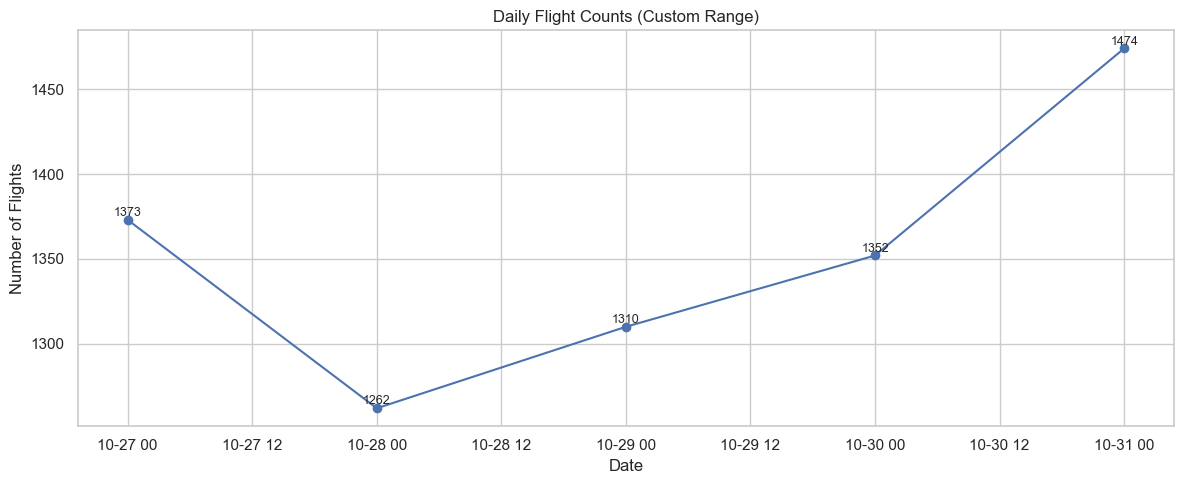

In [33]:
# 📊 Step 22a – Daily Flight Counts Over Time (with values, saved)

import os
os.makedirs("plots", exist_ok=True)  # ensure plots folder exists

# --- Ensure custom_start and custom_end are Timestamps ---
custom_start = pd.to_datetime(custom_start)
custom_end   = pd.to_datetime(custom_end)

# --- Define suffix for the custom date range safely ---
range_suffix = f"{custom_start.strftime('%Y-%m-%d')}_to_{custom_end.strftime('%Y-%m-%d')}"

# Aggregate daily counts for the custom range
daily_counts = flights_range.groupby(flights_range['datetime'].dt.date).size()

plt.figure(figsize=(12,5))
ax = daily_counts.plot(marker='o')
plt.title("Daily Flight Counts (Custom Range)")
plt.xlabel("Date")
plt.ylabel("Number of Flights")

# Annotate each point with its value
for x, y in zip(daily_counts.index, daily_counts.values):
    ax.text(x, y+0.5, str(y), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"plots/Flight_Data_22a_DailyCounts_{range_suffix}.png")
plt.show()


### Step 22b Top Airlines by Flight Volume

This bar chart identifies which airlines operated the most flights during the custom range.  
It provides context on carrier dominance at Dublin Airport in late October 2025.  
Reviewers can see whether the dataset is skewed toward a few airlines or broadly distributed.


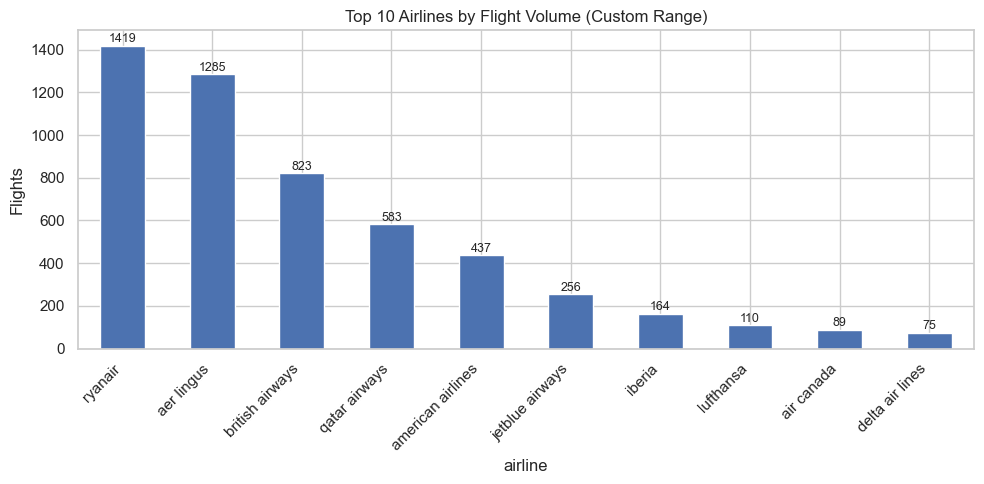

In [34]:
# 📊 Step 22b – Top Airlines by Flight Volume (saved)

# --- Ensure custom_start/custom_end are Timestamps for suffix ---
custom_start = pd.to_datetime(custom_start)
custom_end   = pd.to_datetime(custom_end)
range_suffix = f"{custom_start.strftime('%Y-%m-%d')}_to_{custom_end.strftime('%Y-%m-%d')}"

top_airlines = flights_range['airline'].value_counts().head(10)

plt.figure(figsize=(10,5))
ax = top_airlines.plot(kind='bar')
plt.title("Top 10 Airlines by Flight Volume (Custom Range)")
plt.ylabel("Flights")
plt.xticks(rotation=45, ha='right')

# Annotate values on bars
for i, v in enumerate(top_airlines.values):
    ax.text(i, v+0.5, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f"plots/Flight_Data_22b_TopAirlines_{range_suffix}.png")
plt.show()


### 📊 Step 22c – Daily Total Delay Minutes

This bar chart shows the **total number of delay minutes accumulated each day** within the custom 5‑day range (27–31 Oct 2025).  
By summing delays across all flights per date, it highlights which days experienced the greatest overall disruption.  
The annotated values on each bar make the daily totals transparent, allowing reviewers to quickly compare operational impact across the period.  
This view sets the stage for later analysis, where daily delay burdens can be compared against weather conditions to identify potential correlations.


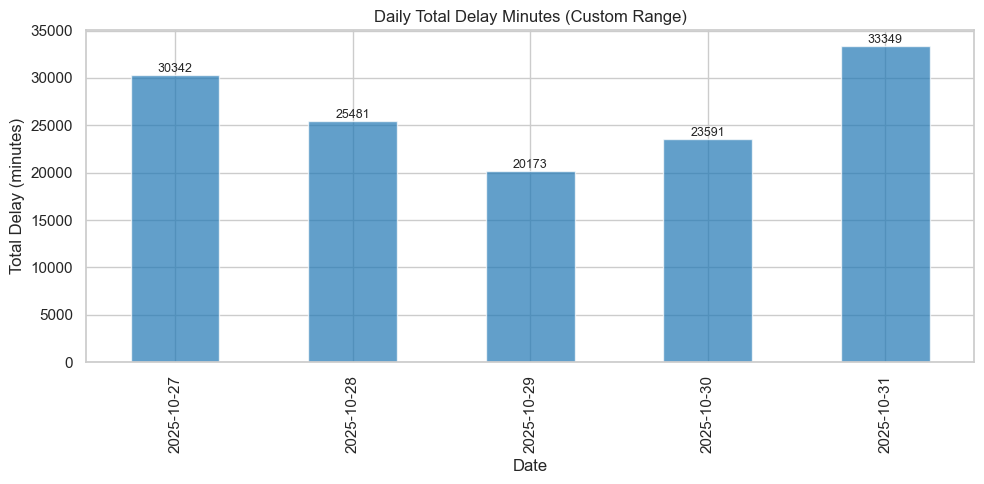

In [35]:
# 📊 Step 22c – Daily Total Delay Minutes (saved, using 'delay')

import os
os.makedirs("plots", exist_ok=True)  # ensure plots folder exists

# --- Ensure custom_start/custom_end are Timestamps for suffix ---
custom_start = pd.to_datetime(custom_start)
custom_end   = pd.to_datetime(custom_end)
range_suffix = f"{custom_start.strftime('%Y-%m-%d')}_to_{custom_end.strftime('%Y-%m-%d')}"

if 'delay' in flights_range.columns:
    # --- Group by date and sum delay minutes ---
    daily_delay_totals = (
        flights_range.dropna(subset=['delay'])
        .groupby(flights_range['datetime'].dt.date)['delay']
        .sum()
    )

    if len(daily_delay_totals) > 0:
        plt.figure(figsize=(10,5))
        ax = daily_delay_totals.plot(kind='bar', color='tab:blue', alpha=0.7)
        plt.title("Daily Total Delay Minutes (Custom Range)")
        plt.xlabel("Date")
        plt.ylabel("Total Delay (minutes)")

        # Annotate values on bars
        for i, v in enumerate(daily_delay_totals.values):
            ax.text(i, v+5, str(int(v)), ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(f"plots/Flight_Data_22c_DailyTotalDelay_{range_suffix}.png")
        plt.show()
    else:
        print("⚠️ No delay data available in this custom range.")
else:
    print("⚠️ Column 'delay' not found in flights_range.")


### 📊 Step 22d – Average Delay by Airline

This horizontal bar chart shows the **average delay minutes per flight** for the top 10 airlines in the custom 5‑day range (27–31 Oct 2025).  
By calculating the mean delay for each carrier, it highlights which airlines tended to run later than others during the period.  
The annotated values on each bar make the averages transparent, allowing reviewers to quickly compare operational performance across carriers.  
This complements Step 22c (daily totals) by shifting focus from overall burden to **per‑flight severity**, setting the stage for later weather correlation analysis.


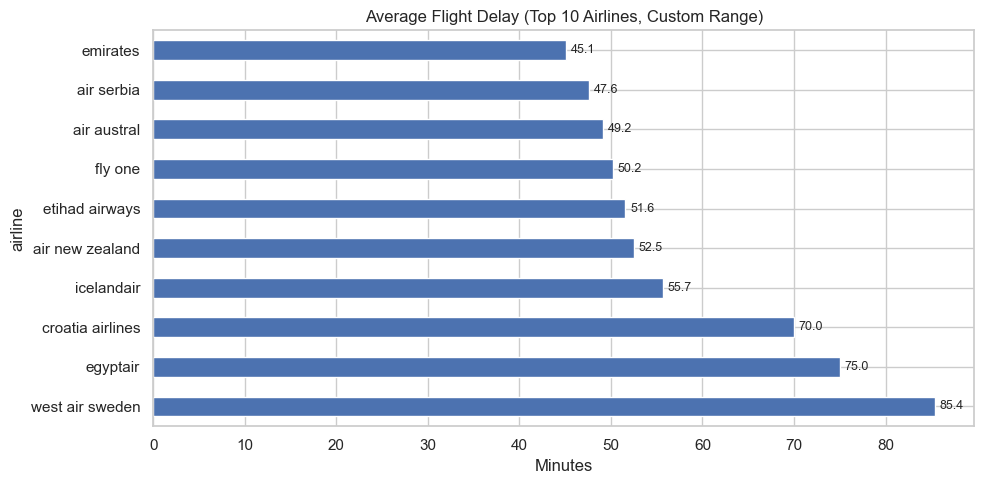

In [36]:
# 📊 Step 22d – Average Delay by Airline (saved, using 'delay')

custom_start = pd.to_datetime(custom_start)
custom_end   = pd.to_datetime(custom_end)
range_suffix = f"{custom_start.strftime('%Y-%m-%d')}_to_{custom_end.strftime('%Y-%m-%d')}"

if 'delay' in flights_range.columns:
    avg_delay = (
        flights_range.groupby('airline')['delay']
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )

    plt.figure(figsize=(10,5))
    ax = avg_delay.plot(kind='barh')
    plt.title("Average Flight Delay (Top 10 Airlines, Custom Range)")
    plt.xlabel("Minutes")

    # Annotate values on bars
    for i, v in enumerate(avg_delay.values):
        ax.text(v+0.5, i, f"{v:.1f}", va='center', fontsize=9)

    plt.tight_layout()
    plt.savefig(f"plots/Flight_Data_22d_AvgDelayByAirline_{range_suffix}.png")
    plt.show()


### 📊 Step 22e – Total Delay Minutes by Airline
This table lists the top 10 airlines ranked by total delay minutes accumulated during the custom 5‑day range (27–31 Oct 2025). It highlights which carriers contributed most to the overall delay burden, complementing Step 22d (average delay per flight). By saving the table to CSV, reviewers can inspect exact values and compare them against flight volumes and weather conditions later.

In [37]:
# 📊 Step 22e – Total Delay Minutes by Airline (Top 10)

custom_start = pd.to_datetime(custom_start)
custom_end   = pd.to_datetime(custom_end)
range_suffix = f"{custom_start.strftime('%Y-%m-%d')}_to_{custom_end.strftime('%Y-%m-%d')}"

if 'delay' in flights_range.columns:
    # --- Group by airline and sum delay minutes ---
    total_delay = (
        flights_range.dropna(subset=['delay'])
        .groupby('airline')['delay']
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    # --- Convert to DataFrame for display ---
    delay_table = total_delay.reset_index()
    delay_table.columns = ['Airline', 'Total Delay Minutes']

    print("Top 10 Airlines by Total Delay Minutes (Custom Range):")
    display(delay_table)

    # --- Save table to CSV for reviewers ---
    delay_table.to_csv(f"plots/Flight_Data_22e_TotalDelayByAirline_{range_suffix}.csv", index=False)
else:
    print("⚠️ Column 'delay' not found in flights_range.")


Top 10 Airlines by Total Delay Minutes (Custom Range):


,Airline,Total Delay Minutes
0,ryanair,28496.0
1,aer lingus,24286.0
2,british airways,16455.0
3,qatar airways,11967.0
4,american airlines,7680.0
5,jetblue airways,4523.0
6,iberia,2858.0
7,kenya airways,1781.0
8,delta air lines,1734.0
9,lufthansa,1495.0


### 📊 Step 23 – Reconfigure Weather & Flight Range (Sliced Date Range)

This step restricts both the **weather dataset** and the **flight dataset** to the same short slice window:  
**27‑Oct‑2025 → 31‑Oct‑2025**.  

- The weather data is filtered to this slice, producing a subset with consistent datetime values.  
- The flight data is also filtered to the same cutoff, ensuring both datasets cover identical periods.  
- Validation prints confirm the number of rows retained and the exact date ranges for each dataset.  
- The `.head()` previews provide reviewers with a quick look at the aligned slices.  

At this stage, no merging or correlation is performed — the sole purpose is to **synchronize the sliced date ranges** of both datasets before deeper analysis.


In [38]:
# 📊 Step 23 – Reconfigure Weather & Flight Range (Sliced Date Range)

import os
os.makedirs("plots", exist_ok=True)

# --- Use the same slice boundaries defined in Step 22 ---
# Example: 2025-10-27 → 2025-10-31
custom_start = pd.Timestamp("2025-10-27 00:00")
custom_end   = pd.Timestamp("2025-10-31 23:59")

# --- Prepare weather dataset with proper datetime ---
range_df = prepare_weather_data(df_weather)

# --- Filter weather data to sliced range ---
range_df = range_df[(range_df['datetime'] >= custom_start) & (range_df['datetime'] <= custom_end)]

print(f"✅ Weather dataset contains {len(range_df)} rows in sliced range")
print(f"📆 Weather range: {range_df['datetime'].min().date()} → {range_df['datetime'].max().date()}")

# --- Filter flight data to same sliced range ---
df_flights = df_flights[(df_flights['datetime'] >= custom_start) & (df_flights['datetime'] <= custom_end)]

print(f"✈️ Flight dataset contains {len(df_flights)} rows in sliced range")
print(f"📆 Flight range: {df_flights['datetime'].min().date()} → {df_flights['datetime'].max().date()}")

# --- Preview aligned slices ---
display(range_df.head())
display(df_flights.head())


✅ Weather dataset contains 120 rows in sliced range
📆 Weather range: 2025-10-27 → 2025-10-31
✈️ Flight dataset contains 6771 rows in sliced range
📆 Flight range: 2025-10-27 → 2025-10-31


,datetime,datetime_hour,temp,rain,wdsp,wddir,vis,clht,ww,w,season,date,hour
708456,2025-10-27 00:00:00,2025-10-27 00:00:00,9.4,0.0,17,260,20000.0,27,2,11,Autumn,2025-10-27,0
708457,2025-10-27 01:00:00,2025-10-27 01:00:00,9.2,0.0,17,270,20000.0,26,2,11,Autumn,2025-10-27,1
708458,2025-10-27 02:00:00,2025-10-27 02:00:00,9.1,0.0,17,270,20000.0,999,2,11,Autumn,2025-10-27,2
708459,2025-10-27 03:00:00,2025-10-27 03:00:00,9.4,0.0,15,270,20000.0,37,2,11,Autumn,2025-10-27,3
708460,2025-10-27 04:00:00,2025-10-27 04:00:00,8.9,0.0,18,270,20000.0,999,2,11,Autumn,2025-10-27,4


,sched,datetime,datetime_hour,delay,delay_calc,airline,flight_iata,status,is_cancelled,type
118413,2025-10-27 00:05:00,2025-10-27 00:05:00,2025-10-27 00:00:00,6.0,6.0,ryanair,fr5218,landed,False,arrival
118414,2025-10-27 00:10:00,2025-10-27 00:10:00,2025-10-27 00:00:00,16.0,16.0,ryanair,fr5239,landed,False,arrival
118415,2025-10-27 00:15:00,2025-10-27 00:15:00,2025-10-27 00:00:00,30.0,30.0,ryanair,fr883,landed,False,arrival
118416,2025-10-27 00:20:00,2025-10-27 00:20:00,2025-10-27 00:00:00,NaN,NaN,ryanair,fr942,landed,False,arrival
118417,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,american airlines,aa8055,landed,False,arrival


### 📊 Step 23a – Match Rate Between Flights and Weather (Sliced Date Range)

This step merges the **flight slice** and the **weather slice** on the `datetime` column, restricted to the short window  
**27‑Oct‑2025 → 31‑Oct‑2025**.  

- It reports the number of flights in the slice.  
- It reports the number of weather observations in the same window.  
- It calculates how many flights successfully matched weather data.  
- The **match rate percentage** shows how representative the merged dataset is.  
- The `.head()` preview confirms the merged structure before deeper analysis.  

This diagnostic ensures that both datasets overlap correctly in the sliced window, preventing silent mismatches before correlation or visualization steps.


In [39]:
# 📊 Step 23a – Merge Flights with Weather (Unified Schema, 5-Day Slice)

# --- Enforce 5-day slice boundaries (from Step 22) ---
custom_start = pd.Timestamp("2025-10-27 00:00")
custom_end   = pd.Timestamp("2025-10-31 23:59")

flights_range = df_flights[(df_flights['datetime'] >= custom_start) & (df_flights['datetime'] <= custom_end)].copy()
range_df      = range_df[(range_df['datetime'] >= custom_start) & (range_df['datetime'] <= custom_end)].copy()

# --- Floor both datasets to nearest hour ---
flights_range['datetime_hour'] = flights_range['datetime'].dt.floor('h')
range_df['datetime_hour']      = range_df['datetime'].dt.floor('h')

# --- Ensure seasons are assigned before merging ---
range_df = assign_season_vectorized(range_df, datetime_col="datetime")

# --- Restrict flight slice to essential schema ---
available_flight_cols = [c for c in essential_flight_cols if c in flights_range.columns]
missing_flight_cols   = [c for c in essential_flight_cols if c not in flights_range.columns]
flights_range = flights_range[available_flight_cols]

print("✅ Flight slice reduced to essential schema")
print(f"Included columns: {available_flight_cols}")
if missing_flight_cols:
    print(f"⚠️ Missing columns (not found in slice): {missing_flight_cols}")

# --- Restrict weather slice to relevant schema ---
available_weather_cols = [c for c in delay_relevant_weather_cols if c in range_df.columns]
missing_weather_cols   = [c for c in delay_relevant_weather_cols if c not in range_df.columns]
range_df = range_df[available_weather_cols]

print("✅ Weather slice reduced to relevant schema")
print(f"Included columns: {available_weather_cols}")
if missing_weather_cols:
    print(f"⚠️ Missing columns (not found in slice): {missing_weather_cols}")

# --- Merge flights with weather schema ---
merged_df = pd.merge(
    flights_range,
    range_df,
    on="datetime_hour",
    how="left",
    validate="m:1"
)

# --- Summary diagnostics ---
total_flights   = len(flights_range)
total_weather   = len(range_df)
matched_flights = len(merged_df)
match_rate      = (matched_flights / total_flights * 100) if total_flights > 0 else 0

flight_min = merged_df['datetime_hour'].min().date()
flight_max = merged_df['datetime_hour'].max().date()
weather_min = range_df['datetime'].min().date()
weather_max = range_df['datetime'].max().date()

weather_match_rate = merged_df['datetime_hour'].notna().mean()
season_match_rate  = merged_df['season'].notna().mean()

print("\n✅ Step 23a Summary (5-Day Slice)")
print(f"📆 Flight range:  {flight_min} → {flight_max}")
print(f"📆 Weather range: {weather_min} → {weather_max}")
print(f"✈️ Flights in sliced range: {total_flights}")
print(f"🌦️ Weather observations in sliced range: {total_weather}")
print(f"🔗 Matched flights with weather: {matched_flights}")
print(f"📈 Match rate: {match_rate:.2f}%")
print(f"🔎 Weather datetime match rate: {weather_match_rate:.1%}")
print(f"🔎 Season assignment rate:     {season_match_rate:.1%}")

# --- Preview merged dataset ---
display(merged_df.head())


✅ Flight slice reduced to essential schema
Included columns: ['sched', 'datetime', 'datetime_hour', 'delay', 'delay_calc', 'airline', 'flight_iata', 'status', 'is_cancelled', 'type']
✅ Weather slice reduced to relevant schema
Included columns: ['datetime', 'datetime_hour', 'temp', 'rain', 'wdsp', 'wddir', 'vis', 'clht', 'ww', 'w', 'season']

✅ Step 23a Summary (5-Day Slice)
📆 Flight range:  2025-10-27 → 2025-10-31
📆 Weather range: 2025-10-27 → 2025-10-31
✈️ Flights in sliced range: 6771
🌦️ Weather observations in sliced range: 120
🔗 Matched flights with weather: 6771
📈 Match rate: 100.00%
🔎 Weather datetime match rate: 100.0%
🔎 Season assignment rate:     100.0%


,sched,datetime_x,datetime_hour,delay,delay_calc,airline,flight_iata,status,is_cancelled,type,datetime_y,temp,rain,wdsp,wddir,vis,clht,ww,w,season
0,2025-10-27 00:05:00,2025-10-27 00:05:00,2025-10-27 00:00:00,6.0,6.0,ryanair,fr5218,landed,False,arrival,2025-10-27 00:00:00,9.4,0.0,17,260,20000.0,27,2,11,Autumn
1,2025-10-27 00:10:00,2025-10-27 00:10:00,2025-10-27 00:00:00,16.0,16.0,ryanair,fr5239,landed,False,arrival,2025-10-27 00:00:00,9.4,0.0,17,260,20000.0,27,2,11,Autumn
2,2025-10-27 00:15:00,2025-10-27 00:15:00,2025-10-27 00:00:00,30.0,30.0,ryanair,fr883,landed,False,arrival,2025-10-27 00:00:00,9.4,0.0,17,260,20000.0,27,2,11,Autumn
3,2025-10-27 00:20:00,2025-10-27 00:20:00,2025-10-27 00:00:00,NaN,NaN,ryanair,fr942,landed,False,arrival,2025-10-27 00:00:00,9.4,0.0,17,260,20000.0,27,2,11,Autumn
4,2025-10-27 04:15:00,2025-10-27 04:15:00,2025-10-27 04:00:00,NaN,NaN,american airlines,aa8055,landed,False,arrival,2025-10-27 04:00:00,8.9,0.0,18,270,20000.0,999,2,11,Autumn


### 📝 Step 23b (Hourly Aggregation of Flights and Weather)

In Step 23b, we take the merged dataset from Step 23a and **summarize it at the hourly level**.  
This makes the data easier to analyze and helps us see patterns between flight delays and weather.

### 1. Flight Aggregation
- **Flights per hour (`flights_count`)**: How many flights happened in each hour.
- **Total delay (`total_delay`)**: The sum of all delay minutes for flights in that hour.
- **Average delay (`avg_delay`)**: The mean delay minutes per flight in that hour.

This shows us how busy each hour was and how delays varied.

### 2. Weather Aggregation
- **Rainfall (`rain_mm`)**: Total rainfall in millimeters for each hour.
- **Temperature (`temp_c`)**: Average temperature during that hour.
- **Wind speed (`wind_kph`)**: Average wind speed during that hour.

This gives us the weather conditions that flights experienced.

### 3. Merge
- We join the **hourly flights** and **hourly weather** datasets on the same `datetime_hour`.
- This ensures each row represents one hour with both flight activity and weather conditions.

### 4. Output
- The final dataset is saved as a CSV file:  
  `data/merged_23b_hourly_flights_weather.csv`
- This file contains one row per hour, with both flight and weather information.
- It is now ready for **correlation analysis** (e.g. do delays increase when rainfall is high?) and for **visualizations**.

### ✅ Why this step matters
By aggregating to the hourly level, we reduce noise from individual flights and make the dataset easier to interpret.  
It allows us to directly compare **flight performance** with **weather conditions** hour by hour.


In [40]:
# 📊 Step 23b – Aggregate Hourly Flight Delays with Weather

# --- Check available columns first ---
print("Columns in merged_df:", merged_df.columns.tolist())
print("Columns in range_df:", range_df.columns.tolist())

# --- Aggregate flights by hour ---
hourly_flights = (
    merged_df
    .groupby('datetime_hour')
    .agg({
        'flight_iata': 'count',     # number of flights
        'delay_calc': 'sum',        # total delay minutes
        'delay_calc': 'mean'        # average delay minutes
    })
    .rename(columns={
        'flight_iata': 'flights_count',
        'delay_calc': 'total_delay'  # careful: rename after aggregation
    })
    .reset_index()
)

# --- Aggregate weather by hour ---
hourly_weather = (
    range_df
    .groupby('datetime_hour')
    .agg({
        'rain': 'sum',
        'temp': 'mean',
        'wdsp': 'mean'
    })
    .rename(columns={
        'rain': 'rain_mm',
        'temp': 'temp_c',
        'wdsp': 'wind_kph'
    })
    .reset_index()
)

# --- Merge aggregated flights with hourly weather ---
hourly_merged = pd.merge(
    hourly_flights,
    hourly_weather,
    on='datetime_hour',
    how='inner',
    validate='1:1'
)

# --- Save to CSV for reproducibility ---
output_path = "data/merged_23b_hourly_flights_weather.csv"
hourly_merged.to_csv(output_path, index=False)

# --- Summary diagnostics ---
print("✅ Step 23b Summary (Hourly Aggregation)")
print(f"Rows in hourly merged dataset: {len(hourly_merged)}")
print("Columns:", hourly_merged.columns.tolist())

# --- Preview aggregated dataset ---
display(hourly_merged.head())


Columns in merged_df: ['sched', 'datetime_x', 'datetime_hour', 'delay', 'delay_calc', 'airline', 'flight_iata', 'status', 'is_cancelled', 'type', 'datetime_y', 'temp', 'rain', 'wdsp', 'wddir', 'vis', 'clht', 'ww', 'w', 'season']
Columns in range_df: ['datetime', 'datetime_hour', 'temp', 'rain', 'wdsp', 'wddir', 'vis', 'clht', 'ww', 'w', 'season']
✅ Step 23b Summary (Hourly Aggregation)
Rows in hourly merged dataset: 120
Columns: ['datetime_hour', 'flights_count', 'total_delay', 'rain_mm', 'temp_c', 'wind_kph']


,datetime_hour,flights_count,total_delay,rain_mm,temp_c,wind_kph
0,2025-10-27 00:00:00,4,17.333333,0.0,9.4,17.0
1,2025-10-27 01:00:00,1,NaN,0.0,9.2,17.0
2,2025-10-27 02:00:00,1,53.000000,0.0,9.1,17.0
3,2025-10-27 03:00:00,1,32.000000,0.0,9.4,15.0
4,2025-10-27 04:00:00,21,29.333333,0.0,8.9,18.0


### Step 24 (Missing Values Analysis)

In Step 24, we load the merged dataset back from file and check for **missing values**.  
This step is important because missing data can affect the accuracy of delay analysis and weather correlations.

#### 1. Load Dataset
- We read the CSV file created earlier (`merged_23b_hourly_flights_weather.csv`).
- This ensures we are working with the saved, reproducible dataset rather than in‑memory variables.

#### 2. Unified Schema
- We restrict the dataset to the relevant columns (flight + weather schema).
- This keeps the analysis focused only on the fields needed for delay and weather comparisons.

#### 3. Missing Value Checks
- **Count of missing values per column**: shows how many gaps exist in each field.
- **Percentage of missing values per column**: expresses the gaps as a percentage of total rows.
- **List of columns with missing values**: highlights which fields need attention.

#### 4. Output
- The printed summary shows both counts and percentages of missing values.
- A preview of the dataset helps confirm which columns are affected.
- This diagnostic step guides decisions about whether to **fill**, **drop**, or **flag** missing data before further analysis.

#### ✅ Why this step matters
By identifying missing values early, we ensure that later steps (such as correlation plots or statistical tests) are based on **clean and reliable data**.  
It also makes the workflow transparent for reviewers, showing exactly where data limitations exist.


In [41]:
# 📊 Step 24 – Analyse Missing Values in Hourly Aggregated Dataset (Step 23b)

import pandas as pd

# --- Load the hourly merged dataset back from file ---
hourly_merged = pd.read_csv("data/merged_23b_hourly_flights_weather.csv", low_memory=False)

# --- Check for missing values across all columns ---
missing_summary = hourly_merged.isna().sum().sort_values(ascending=False)
missing_percent = (hourly_merged.isna().mean() * 100).round(2)
missing_columns = missing_summary[missing_summary > 0].index.tolist()

print("🔎 Missing values per column (hourly merged dataset):")
print(missing_summary)
print("\n📊 Percentage of missing values per column:")
print(missing_percent)
print(f"\n⚠️ Columns with missing values: {missing_columns}")

# --- Preview dataset for context ---
display(hourly_merged.head())


🔎 Missing values per column (hourly merged dataset):
total_delay      2
datetime_hour    0
flights_count    0
rain_mm          0
temp_c           0
wind_kph         0
dtype: int64

📊 Percentage of missing values per column:
datetime_hour    0.00
flights_count    0.00
total_delay      1.67
rain_mm          0.00
temp_c           0.00
wind_kph         0.00
dtype: float64

⚠️ Columns with missing values: ['total_delay']


,datetime_hour,flights_count,total_delay,rain_mm,temp_c,wind_kph
0,2025-10-27 00:00:00,4,17.333333,0.0,9.4,17.0
1,2025-10-27 01:00:00,1,NaN,0.0,9.2,17.0
2,2025-10-27 02:00:00,1,53.000000,0.0,9.1,17.0
3,2025-10-27 03:00:00,1,32.000000,0.0,9.4,15.0
4,2025-10-27 04:00:00,21,29.333333,0.0,8.9,18.0
